In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from markowitz import Data, Parameters, markowitz
from experiments.utils import synthetic_returns
from experiments.backtest import interest_and_fees, OptimizationInput, create_orders, execute_orders, Timing, BacktestResult, run_markowitz, run_backtest
from taming import turnover_limit_markowitz

from tuning import HyperParameters, get_data_and_parameters, full_markowitz, Limits, Targets

# autoreload modules
%load_ext autoreload
%autoreload 2

In [2]:
steps = 750

prices = pd.read_csv("../data/prices.csv", index_col=0, parse_dates=True).iloc[:]
spread = pd.read_csv("../data/spreads.csv", index_col=0, parse_dates=True).iloc[:]
volume = pd.read_csv("../data/volumes.csv", index_col=0, parse_dates=True).iloc[:]
rf = pd.read_csv("../data/rf.csv", index_col=0, parse_dates=True).iloc[:, 0].iloc[:]
# returns = prices.pct_change().dropna()

train_len = 500
test_len = 500

# -500 since first 500 re discarded in backtest
prices_train = prices.iloc[-train_len-test_len-500:-test_len]
prices_test = prices.iloc[-test_len-500:]
spread_train = spread.iloc[-train_len-test_len-500:-test_len]
spread_test = spread.iloc[-test_len-500:]
volume_train = volume.iloc[-train_len-test_len-500:-test_len]
volume_test = volume.iloc[-test_len-500:]
rf_train = rf.iloc[-train_len-test_len-500:-test_len]
rf_test = rf.iloc[-test_len-500:]

prices_train_test = prices.iloc[-train_len-test_len-500:]
spread_train_test = spread.iloc[-train_len-test_len-500:]
volume_train_test = volume.iloc[-train_len-test_len-500:]
rf_train_test = rf.iloc[-train_len-test_len-500:]

returns_train = prices_train.pct_change().dropna()
returns_test = prices_test.pct_change().dropna()

n_assets = prices.shape[1]

In [11]:
from collections import namedtuple
from dataclasses import dataclass
@dataclass
class HyperParameters:
    gamma_hold: float
    gamma_trade: float
    gamma_turn: float
    gamma_leverage: float
    gamma_risk: float


def get_limits_and_targets(
        T_target,
        L_target,
        risk_target,
        T_max,
        L_max,
        risk_max,
):
    targets = Targets(
        T_target=T_target,
        L_target=L_target,
        risk_target=risk_target,
    )

    limits = Limits(
        T_max=T_max,
        L_max=L_max,
        risk_max=risk_max,
    )

    return targets, limits
        

def tune_parameters(
    strategy,
    train_len,
    prices,
    spread,
    volume,
    rf,
):  
    def run_strategy(targets, limits, hyperparameters):
        results, duals = run_markowitz(
            strategy,
            targets=targets,
            limits=limits,
            hyperparameters=hyperparameters,
            prices=prices,
            spread=spread,
            volume=volume,
            rf=rf,
            verbose=False,
        )
        return results, duals
    def sharpes(results):
        returns_train = results.portfolio_returns.iloc[:train_len]
        returns_test = results.portfolio_returns.iloc[train_len:]
        sharpe_train = np.sqrt(252)*returns_train.mean()/returns_train.std()
        sharpe_test = np.sqrt(252)*returns_test.mean()/returns_test.std()

        return sharpe_train, sharpe_test

    # Set initial hyperparameters
    # gamma_zeros = pd.Series(np.zeros(len(prices)), index=prices.index)
    # hyperparameter_list = [1,1,0,0,0]
    # hyperparameter_list = [1,1,2.5e-3,5e-4,5e-2]

    # hyperparameters = HyperParameters(
    #     *hyperparameter_list
    # )

    # targets, limits = get_limits_and_targets(
    #     T_target=0,
    #     L_target=0,
    #     risk_target=0,
    #     T_max=50/252,
    #     L_max=1.6,
    #     risk_max=0.1/np.sqrt(252),
    # )

    # Solve hard problem once
    # results, duals = run_strategy(targets, limits, hyperparameters)
    parameters_to_results = {}
    # parameters_to_results["hard"] = (hyperparameters, results)
    # print(f"Hard Sharpe: {results.sharpe}")
    
    # # Set priorities
    # gamma_turns = max(2e-3, duals.Turnover.quantile(0.5))
    # gamma_leverages = max(5e-4, duals.Leverage.quantile(0.8))
    # gamma_risks = max(5e-2, duals.Risk.quantile(0.5))

    gamma_turns = 2.5e-3
    gamma_leverages = 5e-4
    gamma_risks = 5e-2
    hyperparameter_list = [1,1,gamma_turns,gamma_leverages,gamma_risks]
    hyperparameters = HyperParameters(
        *hyperparameter_list
    )

    # Set soft targets and limits
    targets, limits = get_limits_and_targets(
        T_target=50/252,
        L_target=1.6,
        risk_target=0.1/np.sqrt(252),
        T_max=1,
        L_max=3,
        risk_max=0.3/np.sqrt(252),
    )

    # Initial soft solve
    results, _ = run_strategy(targets, limits, hyperparameters)
    parameters_to_results[0] = (hyperparameters, results)
    print(f"SR first soft: {results.sharpe}")

    
    sharpe_train, sharpe_test = sharpes(results)
    print(f"Initial sharpes: {sharpe_train}, {sharpe_test}")
    sharpe_train_old = sharpe_train
    sharpe_test_old = sharpe_test

    best_iteration = 0
    non_inprove_in_a_row = 0

    n_params = 5
    iteration = 1
    while non_inprove_in_a_row < n_params-1: 
        update_var = iteration % n_params-1 # update all or only first two?
        gamma_temp = hyperparameter_list[update_var] * 1.1

        hyperparameter_list_temp = hyperparameter_list.copy()
        hyperparameter_list_temp[update_var] = gamma_temp

        hyperparameters_temp = HyperParameters(
            *hyperparameter_list_temp
        )

        results, _ = run_strategy(targets, limits, hyperparameters_temp)
        sharpe_train, sharpe_test = sharpes(results)

        if sharpe_train > sharpe_train_old:
            hyperparameter_list = hyperparameter_list_temp.copy()
            hyperparameters = hyperparameters_temp
            best_iteration = iteration
            sharpe_train_old = sharpe_train
            sharpe_test_old = sharpe_test
            non_inprove_in_a_row = 0
        else:
            gamma_temp = hyperparameter_list[update_var] * 0.1
            hyperparameter_list_temp[update_var] = gamma_temp
            hyperparameters_temp = HyperParameters(
                *hyperparameter_list_temp
            )
            results, _ = run_strategy(targets, limits, hyperparameters_temp)
            sharpe_train, sharpe_test = sharpes(results)

            if sharpe_train > sharpe_train_old:
                hyperparameter_list = hyperparameter_list_temp.copy()
                hyperparameters = hyperparameters_temp
                sharpe_train_old = sharpe_train
                sharpe_test_old = sharpe_test
                best_iteration = iteration
                non_inprove_in_a_row = 0

            else:
                non_inprove_in_a_row += 1
                print("In a row: " + str(non_inprove_in_a_row))
            
                        
        parameters_to_results[iteration] = (hyperparameters, results)

        print(f"\nIteration number {iteration}; current sharpes: {sharpe_train_old, sharpe_test_old}")
        print(f"Hyperparameters: {hyperparameters}")
        iteration += 1

    
    return parameters_to_results, best_iteration

In [7]:
def run_strategy(targets, limits, hyperparameters):
        results, duals = run_markowitz(
            full_markowitz,
            targets=targets,
            limits=limits,
            hyperparameters=hyperparameters,
            prices=prices_train_test,
            spread=spread_train_test,
            volume=volume_train_test,
            rf=rf_train_test,
            verbose=False,
        )
        return results, duals

targets, limits = get_limits_and_targets(
        T_target=0,
        L_target=0,
        risk_target=0.1/np.sqrt(252),
        T_max=1e3,
        L_max=1e3,
        risk_max=0.3/np.sqrt(252),
    )

In [8]:
results, duals = run_strategy(targets, limits, HyperParameters(1,1,0,0,0.1))

In [9]:
print(f"mean: {results.mean_return}")
print(f"volatility: {results.volatility}")
print(f"max drawdown: {results.max_drawdown}")
print(f"max leverage: {results.max_leverage}")
print(f"sharpe: {results.sharpe}")
print(f"turnover: {results.turnover}")

mean: 1.3538352957619495
volatility: 0.19009336007620797
max drawdown: -0.049414208115733715
max leverage: 6.131756275917625
sharpe: 7.060800406428157
turnover: 1234.7161513543604


In [12]:
parameter_dict_new, best_iteration = tune_parameters(
    full_markowitz,
    500,
    prices_train_test,
    spread_train_test,
    volume_train_test,
    rf_train_test,
)

In [95]:
sharpe_ratios_train = []
sharpe_ratios_test = []
volas_train = []
volas_test = []
leverages_train = []
leverages_test = []
turnovers_train = []
turnovers_test = []

gamma_holds = []
gamma_trades = []
gamma_turns = []
gamma_leverages = []
gamma_risks = []

def sharpes(results):
        returns_train = results.portfolio_returns.iloc[:train_len]
        returns_test = results.portfolio_returns.iloc[train_len:]
        sharpe_train = np.sqrt(252)*returns_train.mean()/returns_train.std()
        sharpe_test = np.sqrt(252)*returns_test.mean()/returns_test.std()

        return sharpe_train, sharpe_test

def volas(results):
        vola_train = np.sqrt(252)*results.portfolio_returns.iloc[:train_len].std()
        vola_test = np.sqrt(252)*results.portfolio_returns.iloc[train_len:].std()
        
        return vola_train, vola_test

def leverages(results):
        leverage_train = results.asset_weights.abs().iloc[:train_len].sum(axis=1).max()
        leverage_test = results.asset_weights.abs().iloc[train_len:].sum(axis=1).max()
        
        return leverage_train, leverage_test

def turnovers(results):
        trades = results.quantities.diff()
        valuation_trades = (trades * prices).dropna()
        relative_trades = valuation_trades.div(results.portfolio_value, axis=0)

        turnover_train = relative_trades.abs().sum(axis=1).iloc[:train_len].mean() * results.periods_per_year
        turnover_test = relative_trades.abs().sum(axis=1).iloc[train_len:].mean() * results.periods_per_year

        return turnover_train, turnover_test


for i in parameter_dict_new.keys():
    sharpe_train, sharpe_test = sharpes(parameter_dict_new[i][1])
    sharpe_ratios_train.append(sharpe_train)
    sharpe_ratios_test.append(sharpe_test)
    
    vola_train, vola_test = volas(parameter_dict_new[i][1])
    volas_train.append(vola_train)
    volas_test.append(vola_test)
    
    leverage_train, leverage_test = leverages(parameter_dict_new[i][1])
    leverages_train.append(leverage_train)
    leverages_test.append(leverage_test)
    
    turnover_train, turnover_test = turnovers(parameter_dict_new[i][1])
    turnovers_train.append(turnover_train)
    turnovers_test.append(turnover_test)
    
    gamma_holds.append(parameter_dict_new[i][0].gamma_hold)
    gamma_trades.append(parameter_dict_new[i][0].gamma_trade)
    gamma_turns.append(parameter_dict_new[i][0].gamma_turn)
    gamma_leverages.append(parameter_dict_new[i][0].gamma_leverage)
    gamma_risks.append(parameter_dict_new[i][0].gamma_risk)

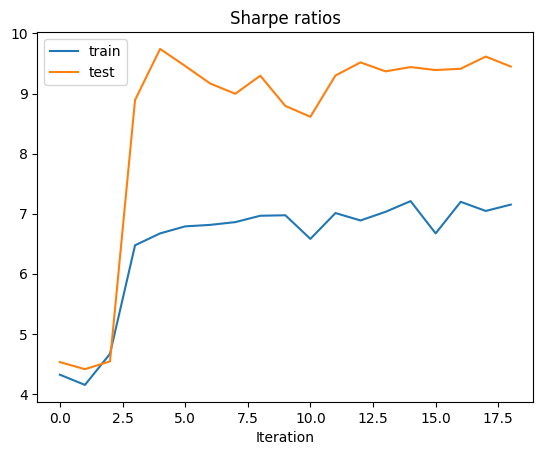

In [96]:
plt.plot(sharpe_ratios_train, label="train")
plt.plot(sharpe_ratios_test, label="test")
plt.title("Sharpe ratios")
plt.xlabel("Iteration")
plt.legend()

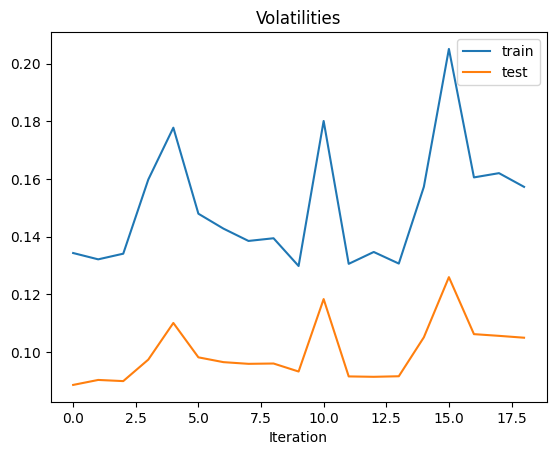

In [97]:
plt.plot(volas_train, label="train")
plt.plot(volas_test, label="test")
plt.title("Volatilities")
plt.xlabel("Iteration")
plt.legend()

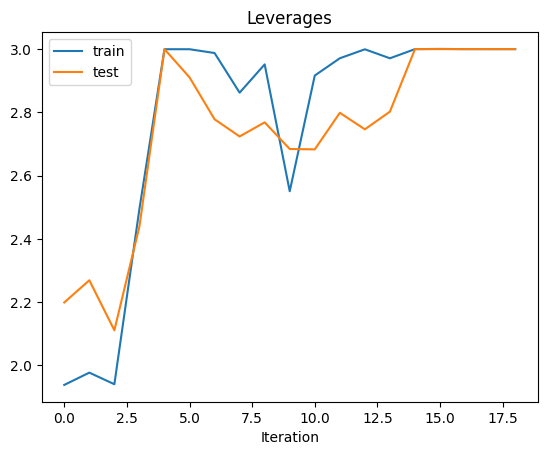

In [98]:
plt.plot(leverages_train, label="train")
plt.plot(leverages_test, label="test")
plt.title("Leverages")
plt.xlabel("Iteration")
plt.legend()

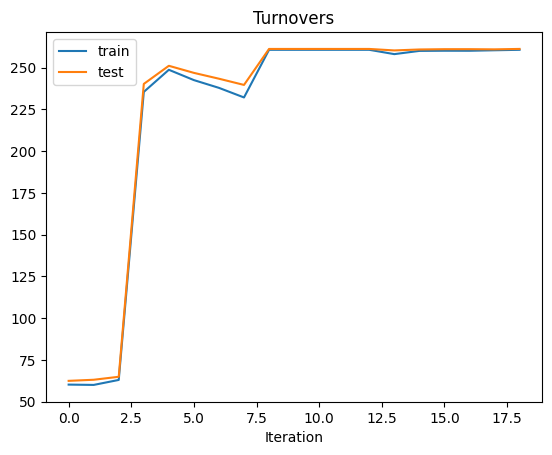

In [99]:
plt.plot(turnovers_train, label="train")
plt.plot(turnovers_test, label="test")
plt.title("Turnovers")
plt.xlabel("Iteration")
plt.legend()

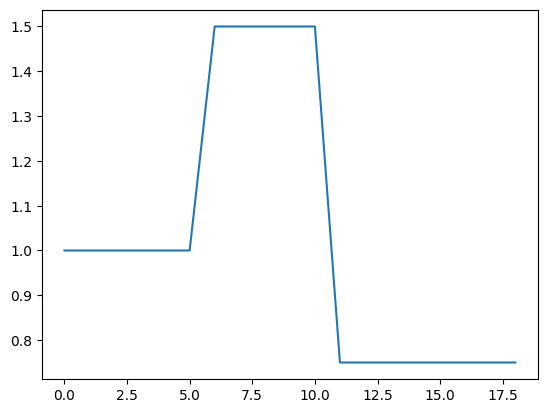

In [100]:
plt.plot(gamma_holds, label="hold")

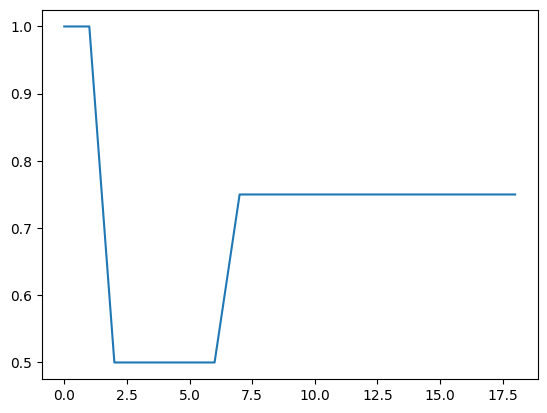

In [101]:
plt.plot(gamma_trades, label="trade")

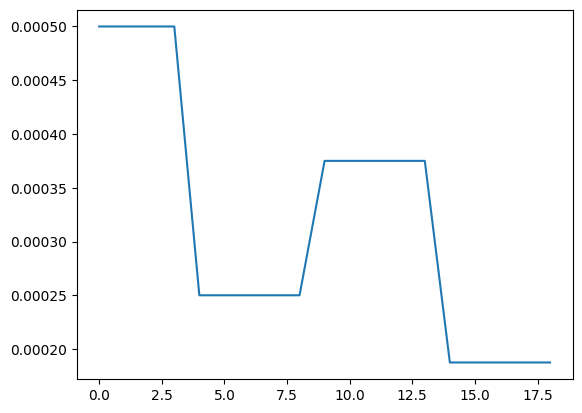

In [102]:
plt.plot(gamma_leverages, label="hold")

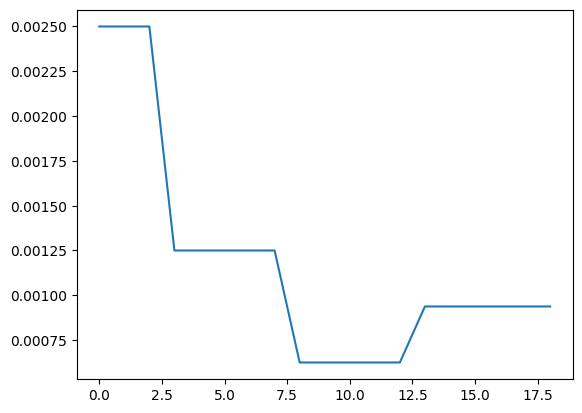

In [103]:
plt.plot(gamma_turns, label="hold")

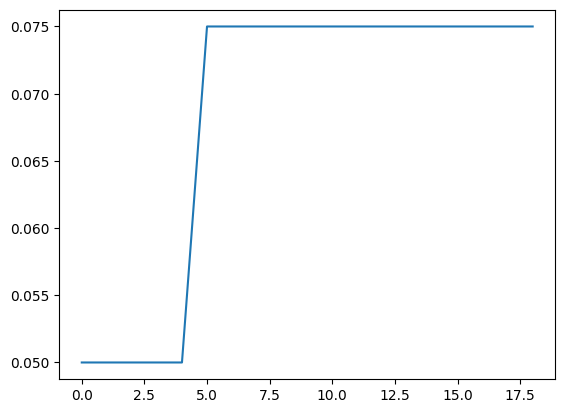

In [104]:
plt.plot(gamma_risks, label="hold")

### Hard

In [5]:
gamma_zeros = pd.Series(np.zeros(len(prices)), index=prices.index)

hyperparameters = HyperParameters(
    1, 1, gamma_zeros, gamma_zeros, gamma_zeros
)

targets = Targets(
    T_target=0,
    L_target=0,
    risk_target=0,
)
limits = Limits(
    T_max=50/252,
    L_max=1.6,
    risk_max=0.1/np.sqrt(252),
)

results_hard, duals_hard = run_markowitz(
            full_markowitz,
            targets=targets,
            limits=limits,
            hyperparameters=hyperparameters,
            verbose=True,
        ) 

Day 500 of 6190, 2001-12-04 00:00:00
Day 600 of 6190, 2002-04-23 00:00:00
Day 700 of 6190, 2002-09-10 00:00:00
Day 800 of 6190, 2003-01-28 00:00:00
Day 900 of 6190, 2003-06-17 00:00:00
Day 1000 of 6190, 2003-11-04 00:00:00
Day 1100 of 6190, 2004-03-23 00:00:00
Day 1200 of 6190, 2004-08-10 00:00:00
Day 1300 of 6190, 2004-12-28 00:00:00
Day 1400 of 6190, 2005-05-17 00:00:00
Day 1500 of 6190, 2005-10-04 00:00:00
Day 1600 of 6190, 2006-02-21 00:00:00
Day 1700 of 6190, 2006-07-11 00:00:00
Day 1800 of 6190, 2006-11-28 00:00:00
Day 1900 of 6190, 2007-04-17 00:00:00
Day 2000 of 6190, 2007-09-04 00:00:00
Day 2100 of 6190, 2008-01-22 00:00:00
Day 2200 of 6190, 2008-06-10 00:00:00
Day 2300 of 6190, 2008-10-28 00:00:00
Day 2400 of 6190, 2009-03-17 00:00:00
Day 2500 of 6190, 2009-08-04 00:00:00
Day 2600 of 6190, 2009-12-22 00:00:00
Day 2700 of 6190, 2010-05-11 00:00:00
Day 2800 of 6190, 2010-09-28 00:00:00
Day 2900 of 6190, 2011-02-15 00:00:00
Day 3000 of 6190, 2011-07-05 00:00:00
Day 3100 of 6190,

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

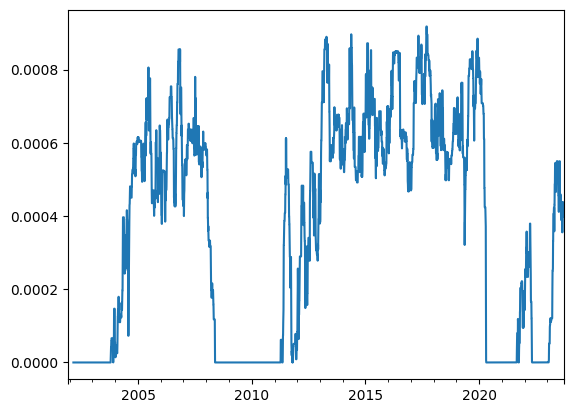

In [25]:
duals_hard.Leverage.rolling(63).quantile(0.8).plot()

In [6]:
duals_hard.Risk.quantile(0.5)

0.03624073932860246

In [41]:
duals_hard.Turnover.quantile(0.5)


0.003025173441200733

In [44]:
duals_hard.Leverage.quantile(0.8)

0.0010060570141882225

In [56]:
print(f"mean: {results_hard.mean_return}")
print(f"volatility: {results_hard.volatility}")
print(f"max drawdown: {results_hard.max_drawdown}")
print(f"max leverage: {results_hard.max_leverage}")
print(f"sharpe: {results_hard.sharpe}")
print(f"turnover: {results_hard.turnover}")

mean: 0.3776696097661857
volatility: 0.10453363781939191
max drawdown: -0.08151149230255672
max leverage: 1.6034244636184998
sharpe: 3.5126898840553364
turnover: 51.713405869465255


### Fixed priorities

In [32]:
duals_hard.Risk.quantile(0.5)

0.03624073932860246

In [34]:
duals_hard.Leverage.quantile(0.8)


0.0004253814761167239

In [35]:
duals_hard.Turnover.quantile(0.5)

0.0024359237523933898

In [59]:
duals_hard.iloc[:500].Risk.quantile(0.1)

0.01601414083345206

In [29]:
gamma_risk = 0.05
gamma_leverage = 0.0005
gamma_turn = 0.002


gamma_turns = pd.Series(np.ones(len(prices)), index=prices.index) * gamma_turn
gamma_leverages = pd.Series(np.ones(len(prices)), index=prices.index) * gamma_leverage
gamma_risks = pd.Series(np.ones(len(prices)), index=prices.index) * gamma_risk


hyperparameters = HyperParameters(
    1, 1, gamma_turns, gamma_leverages, gamma_risks
)

targets = Targets(
    T_target=50/252,
    L_target=1.6,
    risk_target=0.1/np.sqrt(252),
)
limits = Limits(
    T_max=1e3,
    L_max=1e3,
    risk_max=1e3,
)

results_soft_fixed, duals_soft_fixed = run_markowitz(
            full_markowitz,
            targets=targets,
            limits=limits,
            hyperparameters=hyperparameters,
            verbose=True,
        ) 

Day 500 of 6190, 2001-12-04 00:00:00
Day 600 of 6190, 2002-04-23 00:00:00
Day 700 of 6190, 2002-09-10 00:00:00
Day 800 of 6190, 2003-01-28 00:00:00
Day 900 of 6190, 2003-06-17 00:00:00
Day 1000 of 6190, 2003-11-04 00:00:00
Day 1100 of 6190, 2004-03-23 00:00:00
Day 1200 of 6190, 2004-08-10 00:00:00
Day 1300 of 6190, 2004-12-28 00:00:00
Day 1400 of 6190, 2005-05-17 00:00:00
Day 1500 of 6190, 2005-10-04 00:00:00
Day 1600 of 6190, 2006-02-21 00:00:00
Day 1700 of 6190, 2006-07-11 00:00:00
Day 1800 of 6190, 2006-11-28 00:00:00
Day 1900 of 6190, 2007-04-17 00:00:00
Day 2000 of 6190, 2007-09-04 00:00:00
Day 2100 of 6190, 2008-01-22 00:00:00
Day 2200 of 6190, 2008-06-10 00:00:00
Day 2300 of 6190, 2008-10-28 00:00:00
Day 2400 of 6190, 2009-03-17 00:00:00
Day 2500 of 6190, 2009-08-04 00:00:00
Day 2600 of 6190, 2009-12-22 00:00:00
Day 2700 of 6190, 2010-05-11 00:00:00
Day 2800 of 6190, 2010-09-28 00:00:00
Day 2900 of 6190, 2011-02-15 00:00:00
Day 3000 of 6190, 2011-07-05 00:00:00
Day 3100 of 6190,

In [70]:
gamma_risk = 0.05
gamma_turn = 0.0025
gamma_leverage = 0.0005

gamma_turns = pd.Series(np.ones(len(prices)), index=prices.index) * gamma_turn
gamma_leverages = (
    pd.Series(np.ones(len(prices)), index=prices.index) * gamma_leverage
)
gamma_risks = pd.Series(np.ones(len(prices)), index=prices.index) * gamma_risk

hyperparameters = HyperParameters(1, 1, gamma_turns, gamma_leverages, gamma_risks)

targets = Targets(
    T_target=50 / 252,
    L_target=1.6,
    risk_target=0.1 / np.sqrt(252),
)
limits = Limits(
    T_max=1e3,
    L_max=1e3,
    risk_max=1e3,
)

results, duals = run_markowitz(
    full_markowitz,
    targets=targets,
    limits=limits,
    hyperparameters=hyperparameters,
    verbose=True,
)

Day 500 of 6190, 2001-12-04 00:00:00
Day 600 of 6190, 2002-04-23 00:00:00
Day 700 of 6190, 2002-09-10 00:00:00
Day 800 of 6190, 2003-01-28 00:00:00
Day 900 of 6190, 2003-06-17 00:00:00
Day 1000 of 6190, 2003-11-04 00:00:00
Day 1100 of 6190, 2004-03-23 00:00:00
Day 1200 of 6190, 2004-08-10 00:00:00
Day 1300 of 6190, 2004-12-28 00:00:00
Day 1400 of 6190, 2005-05-17 00:00:00
Day 1500 of 6190, 2005-10-04 00:00:00
Day 1600 of 6190, 2006-02-21 00:00:00
Day 1700 of 6190, 2006-07-11 00:00:00
Day 1800 of 6190, 2006-11-28 00:00:00
Day 1900 of 6190, 2007-04-17 00:00:00
Day 2000 of 6190, 2007-09-04 00:00:00
Day 2100 of 6190, 2008-01-22 00:00:00
Day 2200 of 6190, 2008-06-10 00:00:00
Day 2300 of 6190, 2008-10-28 00:00:00
Day 2400 of 6190, 2009-03-17 00:00:00
Day 2500 of 6190, 2009-08-04 00:00:00
Day 2600 of 6190, 2009-12-22 00:00:00
Day 2700 of 6190, 2010-05-11 00:00:00
Day 2800 of 6190, 2010-09-28 00:00:00
Day 2900 of 6190, 2011-02-15 00:00:00
Day 3000 of 6190, 2011-07-05 00:00:00
Day 3100 of 6190,

In [69]:
print(f"mean: {results.mean_return}")
print(f"volatility: {results.volatility}")
print(f"max drawdown: {results.max_drawdown}")
print(f"max leverage: {results.max_leverage}")
print(f"sharpe: {results.sharpe}")
print(f"turnover: {results.turnover}")

mean: 0.44013548152118886
volatility: 0.10083217736721517
max drawdown: -0.052475758616973955
max leverage: 2.18224701854325
sharpe: 4.260724991145439
turnover: 67.01445674865148


In [64]:
print(f"mean: {results.mean_return}")
print(f"volatility: {results.volatility}")
print(f"max drawdown: {results.max_drawdown}")
print(f"max leverage: {results.max_leverage}")
print(f"sharpe: {results.sharpe}")
print(f"turnover: {results.turnover}")

mean: 0.5571573399619121
volatility: 0.10717523630289773
max drawdown: -0.06056368630300013
max leverage: 2.524529891306238
sharpe: 5.10011042759034
turnover: 103.82955958906315


In [60]:
print(f"mean: {results_soft_fixed.mean_return}")
print(f"volatility: {results_soft_fixed.volatility}")
print(f"max drawdown: {results_soft_fixed.max_drawdown}")
print(f"max leverage: {results_soft_fixed.max_leverage}")
print(f"sharpe: {results_soft_fixed.sharpe}")
print(f"turnover: {results_soft_fixed.turnover}")

mean: 1.6824803181255783
volatility: 0.2552101981365625
max drawdown: -0.09327393196229872
max leverage: 5.977830783876957
sharpe: 6.550981607466132
turnover: 434.9780213455417


In [28]:
print(f"mean: {results_soft_fixed.mean_return}")
print(f"volatility: {results_soft_fixed.volatility}")
print(f"max drawdown: {results_soft_fixed.max_drawdown}")
print(f"max leverage: {results_soft_fixed.max_leverage}")
print(f"sharpe: {results_soft_fixed.sharpe}")
print(f"turnover: {results_soft_fixed.turnover}")

mean: 0.5571573399619121
volatility: 0.10717523630289773
max drawdown: -0.06056368630300013
max leverage: 2.524529891306238
sharpe: 5.10011042759034
turnover: 103.82955958906315


In [27]:
print(f"mean: {results_soft_fixed.mean_return}")
print(f"volatility: {results_soft_fixed.volatility}")
print(f"max drawdown: {results_soft_fixed.max_drawdown}")
print(f"max leverage: {results_soft_fixed.max_leverage}")
print(f"sharpe: {results_soft_fixed.sharpe}")
print(f"turnover: {results_soft_fixed.turnover}")

mean: 0.5571573399619121
volatility: 0.10717523630289773
max drawdown: -0.06056368630300013
max leverage: 2.524529891306238
sharpe: 5.10011042759034
turnover: 103.82955958906315


In [14]:
print(f"mean: {results_soft_fixed.mean_return}")
print(f"volatility: {results_soft_fixed.volatility}")
print(f"max drawdown: {results_soft_fixed.max_drawdown}")
print(f"max leverage: {results_soft_fixed.max_leverage}")
print(f"sharpe: {results_soft_fixed.sharpe}")
print(f"turnover: {results_soft_fixed.turnover}")

mean: 0.46558894278731994
volatility: 0.111299584876146
max drawdown: -0.0646629299069752
max leverage: 2.537019975833859
sharpe: 4.089254923871746
turnover: 72.05809021990075


In [15]:
results_soft_fixed.cash_weight.mean()

0.7214265619667974

### Moving priorities

In [24]:
gamma_turns = duals_hard.Turnover.ffill().rolling(100, min_periods=1).quantile(0.5)
gamma_leverages = duals_hard.Leverage.ffill().rolling(100, min_periods=1).quantile(0.8)
gamma_risks = duals_hard.Risk.ffill().rolling(100, min_periods=1).quantile(0.5)

hyperparameters = HyperParameters(
    1, 1, gamma_turns, gamma_leverages, gamma_risks
)

targets = Targets(
    T_target=50/252,
    L_target=1.6,
    risk_target=0.1/np.sqrt(252),
)
limits = Limits(
    T_max=1e3,
    L_max=1e3,
    risk_max=1e3,
)

results_soft_rolling, duals_soft_rolling = run_markowitz(
            full_markowitz,
            prices,
            spread,
            volume,
            rf,
            targets=targets,
            limits=limits,
            hyperparameters=hyperparameters,
            verbose=True,
        ) 

Day 500 of 6190, 2001-12-04 00:00:00
Day 600 of 6190, 2002-04-23 00:00:00
Day 700 of 6190, 2002-09-10 00:00:00
Day 800 of 6190, 2003-01-28 00:00:00
Day 900 of 6190, 2003-06-17 00:00:00
Day 1000 of 6190, 2003-11-04 00:00:00
Day 1100 of 6190, 2004-03-23 00:00:00
Day 1200 of 6190, 2004-08-10 00:00:00
Day 1300 of 6190, 2004-12-28 00:00:00
Day 1400 of 6190, 2005-05-17 00:00:00
Day 1500 of 6190, 2005-10-04 00:00:00
Day 1600 of 6190, 2006-02-21 00:00:00
Day 1700 of 6190, 2006-07-11 00:00:00
Day 1800 of 6190, 2006-11-28 00:00:00
Day 1900 of 6190, 2007-04-17 00:00:00
Day 2000 of 6190, 2007-09-04 00:00:00
Day 2100 of 6190, 2008-01-22 00:00:00
Day 2200 of 6190, 2008-06-10 00:00:00
Day 2300 of 6190, 2008-10-28 00:00:00
Day 2400 of 6190, 2009-03-17 00:00:00
Day 2500 of 6190, 2009-08-04 00:00:00
Day 2600 of 6190, 2009-12-22 00:00:00
Day 2700 of 6190, 2010-05-11 00:00:00
Day 2800 of 6190, 2010-09-28 00:00:00
Day 2900 of 6190, 2011-02-15 00:00:00
Day 3000 of 6190, 2011-07-05 00:00:00
Day 3100 of 6190,

In [77]:
synthetic_returns(prices, 0.15, 5)

,T0,T1,T3,T4,T5,T6,T7,T8,T9,T10,...,T89,T90,T92,T93,T94,T95,T96,T98,T99,T100
2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,0.000496,0.000889,-0.000196,-0.001697,-0.000214,-0.000252,0.001034,0.000906,-0.002095,-0.000724,...,0.000397,-0.001384,-0.001148,0.001473,0.000909,-0.000021,0.000263,-0.000731,0.000264,0.000659
2000-01-06,0.000627,-0.001284,0.001299,-0.000575,-0.001516,-0.000912,0.000049,0.002092,-0.001500,0.000317,...,-0.000016,-0.000709,0.000109,-0.001023,0.000207,-0.000452,-0.000249,0.000314,-0.000227,0.001276
2000-01-07,-0.000278,-0.000395,-0.001053,-0.000641,-0.001814,0.000491,-0.000639,-0.000432,0.000324,0.000403,...,0.000260,-0.000887,-0.001716,-0.000176,-0.000228,0.001155,-0.000017,0.001514,0.000366,0.000620
2000-01-10,-0.000870,0.000426,0.002649,-0.000523,-0.000768,-0.000329,-0.000352,-0.000435,0.000044,-0.000347,...,0.000537,0.001360,-0.000924,0.000128,0.000232,0.001127,0.000499,-0.002068,0.000871,0.001374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-20,-0.001792,-0.000550,-0.001892,-0.000541,-0.001555,0.002783,0.001396,-0.000915,-0.000134,-0.001108,...,0.000128,0.000821,0.000152,-0.000507,0.000499,-0.000460,0.000440,0.002192,-0.000569,0.001662
2023-09-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
a = np.random.default_rng(1)

a.normal(1)

1.345584192064786

In [25]:
print(f"mean: {results_hard.mean_return}")
print(f"volatility: {results_hard.volatility}")
print(f"max drawdown: {results_hard.max_drawdown}")
print(f"max leverage: {results_hard.max_leverage}")
print(f"sharpe: {results_hard.sharpe}")
print(f"turnover: {results_hard.turnover}")

mean: 0.3168587894810624
volatility: 0.08018555982341476
max drawdown: -0.06508470082551443
max leverage: 1.600546737716088
sharpe: 3.821154016945492
turnover: 51.76921141241235


In [26]:
print(f"mean: {results_soft_fixed.mean_return}")
print(f"volatility: {results_soft_fixed.volatility}")
print(f"max drawdown: {results_soft_fixed.max_drawdown}")
print(f"max leverage: {results_soft_fixed.max_leverage}")
print(f"sharpe: {results_soft_fixed.sharpe}")
print(f"turnover: {results_soft_fixed.turnover}")

mean: 0.46558894278731994
volatility: 0.111299584876146
max drawdown: -0.0646629299069752
max leverage: 2.537019975833859
sharpe: 4.089254923871746
turnover: 72.05809021990075


In [27]:
print(f"mean: {results_soft_rolling.mean_return}")
print(f"volatility: {results_soft_rolling.volatility}")
print(f"max drawdown: {results_soft_rolling.max_drawdown}")
print(f"max leverage: {results_soft_rolling.max_leverage}")
print(f"sharpe: {results_soft_rolling.sharpe}")
print(f"turnover: {results_soft_rolling.turnover}")

mean: 0.5084854292295689
volatility: 0.1242379585884588
max drawdown: -0.08722662120820734
max leverage: 3.06024481945951
sharpe: 4.008947845127499
turnover: 69.84790188452702


In [19]:
1

1

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

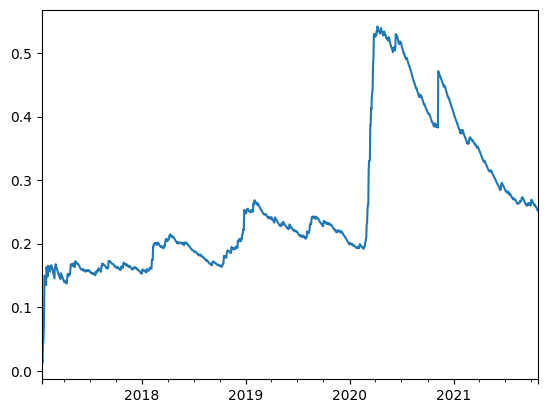

In [54]:
(results.portfolio_returns.ewm(halflife=63).std() * np.sqrt(252)).plot()

In [50]:
results.sharpe

2.9497855621832763

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

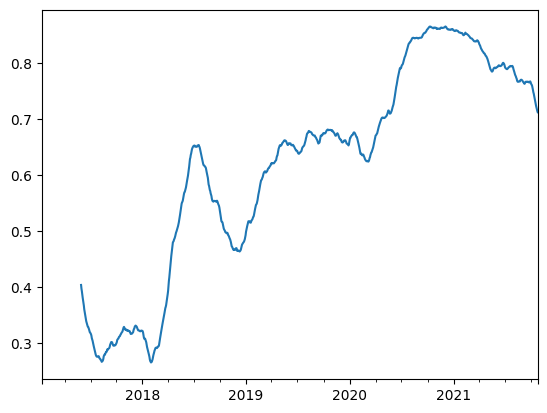

In [19]:
results.cash_weight.rolling(100).mean().plot()

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

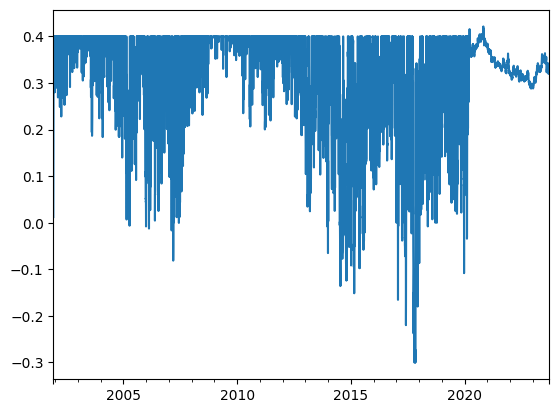

In [149]:
results.cash_weight.plot()

In [145]:
rf*252

2000-01-04    0.03766
2000-01-05    0.03787
2000-01-06    0.03878
2000-01-07    0.03927
2000-01-10    0.04018
               ...   
2023-09-20    0.03731
2023-09-21    0.03731
2023-09-22    0.03731
2023-09-25    0.03731
2023-09-26    0.03731
Name: DFF, Length: 6191, dtype: float64

In [166]:
gamma_zeros = pd.Series(np.zeros(len(prices)), index=prices.index)

hyperparameters = HyperParameters(
    1, 1, gamma_zeros, gamma_zeros, gamma_zeros
)

targets = Targets(
    T_target=0,
    L_target=0,
    risk_target=0,
)
limits = Limits(
    T_max=50/252,
    L_max=1.6,
    risk_max=0.15/np.sqrt(252),
)

results, duals = run_markowitz(
            full_markowitz,
            prices,
            spread,
            volume,
            rf,
            targets=targets,
            limits=limits,
            hyperparameters=hyperparameters,
            hard=False,
            verbose=True,
        ) 

Day 500 of 6190, 2001-12-04 00:00:00
Day 600 of 6190, 2002-04-23 00:00:00
Day 700 of 6190, 2002-09-10 00:00:00


/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1395: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Day 800 of 6190, 2003-01-28 00:00:00
Day 900 of 6190, 2003-06-17 00:00:00
Day 1000 of 6190, 2003-11-04 00:00:00
Day 1100 of 6190, 2004-03-23 00:00:00
Day 1200 of 6190, 2004-08-10 00:00:00
Day 1300 of 6190, 2004-12-28 00:00:00
Day 1400 of 6190, 2005-05-17 00:00:00
Day 1500 of 6190, 2005-10-04 00:00:00
Day 1600 of 6190, 2006-02-21 00:00:00
Day 1700 of 6190, 2006-07-11 00:00:00
Day 1800 of 6190, 2006-11-28 00:00:00
Day 1900 of 6190, 2007-04-17 00:00:00
Day 2000 of 6190, 2007-09-04 00:00:00
Day 2100 of 6190, 2008-01-22 00:00:00
Day 2200 of 6190, 2008-06-10 00:00:00
Day 2300 of 6190, 2008-10-28 00:00:00
Day 2400 of 6190, 2009-03-17 00:00:00
Day 2500 of 6190, 2009-08-04 00:00:00
Day 2600 of 6190, 2009-12-22 00:00:00
Day 2700 of 6190, 2010-05-11 00:00:00
Day 2800 of 6190, 2010-09-28 00:00:00
Day 2900 of 6190, 2011-02-15 00:00:00
Day 3000 of 6190, 2011-07-05 00:00:00
Day 3100 of 6190, 2011-11-22 00:00:00
Day 3200 of 6190, 2012-04-10 00:00:00
Day 3300 of 6190, 2012-08-28 00:00:00
Day 3400 of 61

In [51]:
print(f"mean: {results.mean_return}")
print(f"volatility: {results.volatility}")
print(f"max drawdown: {results.max_drawdown}")
print(f"max leverage: {results.max_leverage}")
print(f"sharpe: {results.sharpe}")
print(f"turnover: {results.turnover}")

mean: 0.8635092229646663
volatility: 0.2927362700648457
max drawdown: -0.18559613060231173
max leverage: 6.5980273013555415
sharpe: 2.9497855621832763
turnover: 1135.0950865605707


In [165]:
gamma_risks.mean()

0.02506846771012686

In [155]:
gamma_turn = duals["Turnover"].quantile(0.5)
gamma_leverage = duals["Leverage"].quantile(0.8)
gamma_risk = duals["Risk"].quantile(0.5)

gamma_turns = duals.Turnover.rolling(100, min_periods=1).quantile(0.1).ffill()
gamma_leverages = duals.Leverage.rolling(100, min_periods=1).quantile(0.9).ffill()
gamma_risks = duals.Risk.rolling(100, min_periods=1).quantile(0.5).ffill()

hyperparameters = HyperParameters(
    gamma_hold=1, 
    gamma_trade=1, 
    gamma_turn=gamma_turns, 
    gamma_leverage=gamma_leverages, 
    gamma_risk=gamma_risks,
)

targets = Targets(
    T_target=50/252,
    L_target=1.6,
    risk_target=0.15/np.sqrt(252),
)
limits = Limits(
    T_max=1e6,
    L_max=1e6,
    risk_max=1e6,
)

results2, duals2 = run_markowitz(
            full_markowitz,
            prices,
            spread,
            volume,
            rf,
            targets=targets,
            limits=limits,
            hyperparameters=hyperparameters,
            hard=False,
            verbose=True,
        )

Day 500 of 6190, 2001-12-04 00:00:00
Day 600 of 6190, 2002-04-23 00:00:00
Day 700 of 6190, 2002-09-10 00:00:00
Day 800 of 6190, 2003-01-28 00:00:00
Day 900 of 6190, 2003-06-17 00:00:00
Day 1000 of 6190, 2003-11-04 00:00:00
Day 1100 of 6190, 2004-03-23 00:00:00
Day 1200 of 6190, 2004-08-10 00:00:00
Day 1300 of 6190, 2004-12-28 00:00:00
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None


/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1395: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


SolverError
None
Problem status:  None
Day 1400 of 6190, 2005-05-17 00:00:00
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
Day 1500 of 6190, 2005-10-04 00:00:00
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem st

In [156]:
duals.Turnover.isna().sum() / len(duals)

0.16309314586994728

In [140]:
results.cash_weight.max()

0.4213224705984638

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

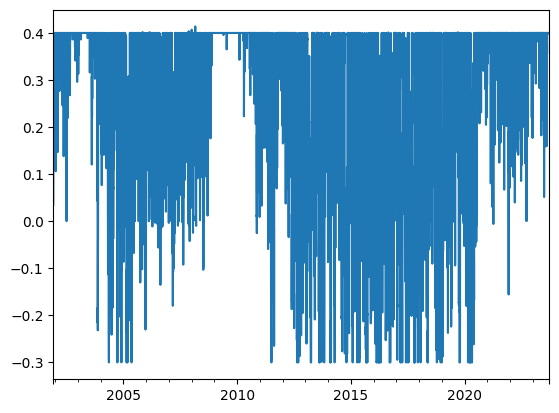

In [158]:
results2.cash_weight.plot()

In [159]:
print(f"mean: {results.mean_return}")
print(f"volatility: {results.volatility}")
print(f"max drawdown: {results.max_drawdown}")
print(f"max leverage: {results.max_leverage}")
print(f"sharpe: {results.sharpe}")
print(f"turnover: {results.turnover}")

mean: 0.061805260862413766
volatility: 0.14288361775842023
max drawdown: -0.39194141340553956
max leverage: 3.6950963931884804
sharpe: 0.43255666277229
turnover: 47.605283050731444


In [160]:
print(f"mean: {results2.mean_return}")
print(f"volatility: {results2.volatility}")
print(f"max drawdown: {results2.max_drawdown}")
print(f"max leverage: {results2.max_leverage}")
print(f"sharpe: {results2.sharpe}")
print(f"turnover: {results2.turnover}")

mean: 0.061929251794935636
volatility: 0.1730963124332527
max drawdown: -0.4359779910394881
max leverage: 4.8802986164449615
sharpe: 0.35777337439707757
turnover: 110.20969532988059


In [49]:
print(f"mean: {results2.mean_return}")
print(f"volatility: {results2.volatility}")
print(f"max drawdown: {results2.max_drawdown}")
print(f"max leverage: {results2.max_leverage}")
print(f"sharpe: {results2.sharpe}")
print(f"turnover: {results2.turnover}")

mean: 0.05925055816284527
volatility: 0.11159393696607192
max drawdown: -0.23411094181749192
max leverage: 1.7226859919667947
sharpe: 0.5309478254258501
turnover: 55.111606334077656


In [36]:
print(f"mean: {results2.mean_return}")
print(f"volatility: {results2.volatility}")
print(f"max drawdown: {results2.max_drawdown}")
print(f"max leverage: {results2.max_leverage}")
print(f"sharpe: {results2.sharpe}")
print(f"turnover: {results2.turnover}")

mean: 0.059743591886659314
volatility: 0.11015180164839075
max drawdown: -0.22449478774537934
max leverage: 1.749674175529416
sharpe: 0.5423750768722186
turnover: 55.041133443536665


/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

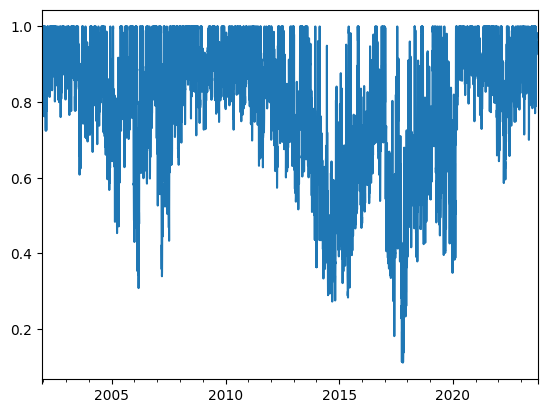

In [52]:
results.cash_weight.plot()

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

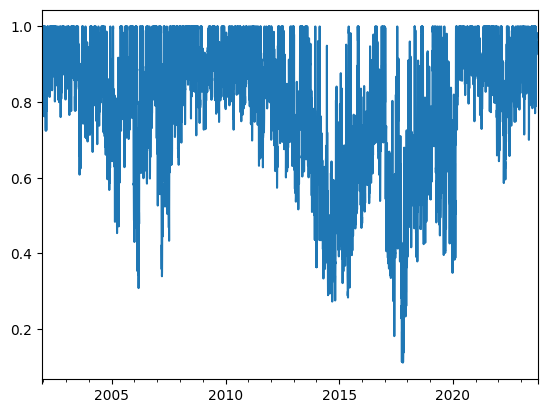

In [56]:
results.cash_weight.plot()

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

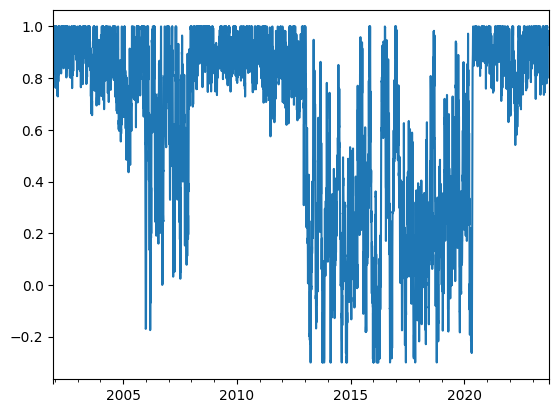

In [51]:
results2.cash_weight.plot()

In [18]:
print(f"mean: {results.mean_return}")
print(f"volatility: {results.volatility}")
print(f"max drawdown: {results.max_drawdown}")
print(f"max leverage: {results.max_leverage}")
print(f"sharpe: {results.sharpe}")
print(f"turnover: {results.turnover}")

mean: 0.07806049414973948
volatility: 0.0864092072236494
max drawdown: -0.12276728404546744
max leverage: 1.6001132457714724
sharpe: 0.9033816725999894
turnover: 54.88883066359304


In [19]:
print(f"mean: {results2.mean_return}")
print(f"volatility: {results2.volatility}")
print(f"max drawdown: {results2.max_drawdown}")
print(f"max leverage: {results2.max_leverage}")
print(f"sharpe: {results2.sharpe}")
print(f"turnover: {results2.turnover}")

mean: 0.12427344655214911
volatility: 0.10723979874675486
max drawdown: -0.1913216585048766
max leverage: 1.7227424750442972
sharpe: 1.158836998991568
turnover: 54.75863135003089


In [21]:
print(f"mean: {results2.mean_return}")
print(f"volatility: {results2.volatility}")
print(f"max drawdown: {results2.max_drawdown}")
print(f"max leverage: {results2.max_leverage}")
print(f"sharpe: {results2.sharpe}")
print(f"turnover: {results2.turnover}")

mean: 0.11770992976245821
volatility: 0.14492892749813072
max drawdown: -0.23206098485749815
max leverage: 1.494933697164318
sharpe: 0.812190718543587
turnover: 52.543953029128545


In [23]:
print(f"mean: {results2.mean_return}")
print(f"volatility: {results2.volatility}")
print(f"max drawdown: {results2.max_drawdown}")
print(f"max leverage: {results2.max_leverage}")
print(f"sharpe: {results2.sharpe}")
print(f"turnover: {results2.turnover}")

mean: 0.0591100891243838
volatility: 0.090228798050163
max drawdown: -0.10525915380271766
max leverage: 1.919951771504085
sharpe: 0.6551133385542979
turnover: 55.11648802167524


In [25]:
print(f"mean: {results2.mean_return}")
print(f"volatility: {results2.volatility}")
print(f"max drawdown: {results2.max_drawdown}")
print(f"max leverage: {results2.max_leverage}")
print(f"sharpe: {results2.sharpe}")
print(f"turnover: {results2.turnover}")

mean: 0.10548705769841667
volatility: 0.10521770296138792
max drawdown: -0.22155491045540587
max leverage: 1.8598160396092196
sharpe: 1.002559975455153
turnover: 54.75302901859191


In [27]:
print(f"mean: {results2.mean_return}")
print(f"volatility: {results2.volatility}")
print(f"max drawdown: {results2.max_drawdown}")
print(f"max leverage: {results2.max_leverage}")
print(f"sharpe: {results2.sharpe}")
print(f"turnover: {results2.turnover}")

mean: 0.11945965017469508
volatility: 0.10754735305564805
max drawdown: -0.15218095978938673
max leverage: 1.7869691131510583
sharpe: 1.11076327571617
turnover: 54.63671849166984


In [274]:
gamma_turn = duals["Turnover"].quantile(0.8)
gamma_leverage = duals2["Leverage"].quantile(0.8)
gamma_risk = duals2["Risk"].quantile(0.8)
hyperparameters = HyperParameters(
    gamma_hold=0, 
    gamma_trade=0, 
    gamma_turn=gamma_turn, 
    gamma_leverage=gamma_leverage, 
    gamma_risk=gamma_risk,
)

targets = Targets(
    T_target=10/252,
    L_target=1.6,
    risk_target=0.1/np.sqrt(252),
)
limits = Limits(
    T_max=1e6,
    L_max=1e6,
    risk_max=1e6,
)

results3, duals3 = run_markowitz(
            full_markowitz,
            prices,
            spread,
            volume,
            rf,
            targets=targets,
            limits=limits,
            hyperparameters=hyperparameters,
            hard=False,
            verbose=True,
        )

Day 500 of 6190, 2001-12-04 00:00:00
Day 600 of 6190, 2002-04-23 00:00:00
Day 700 of 6190, 2002-09-10 00:00:00
Day 800 of 6190, 2003-01-28 00:00:00
Day 900 of 6190, 2003-06-17 00:00:00
Day 1000 of 6190, 2003-11-04 00:00:00
Day 1100 of 6190, 2004-03-23 00:00:00
Day 1200 of 6190, 2004-08-10 00:00:00
Day 1300 of 6190, 2004-12-28 00:00:00
Day 1400 of 6190, 2005-05-17 00:00:00
Day 1500 of 6190, 2005-10-04 00:00:00
Day 1600 of 6190, 2006-02-21 00:00:00
Day 1700 of 6190, 2006-07-11 00:00:00
Day 1800 of 6190, 2006-11-28 00:00:00
Day 1900 of 6190, 2007-04-17 00:00:00
Day 2000 of 6190, 2007-09-04 00:00:00
Day 2100 of 6190, 2008-01-22 00:00:00
Day 2200 of 6190, 2008-06-10 00:00:00
Day 2300 of 6190, 2008-10-28 00:00:00
Day 2400 of 6190, 2009-03-17 00:00:00
Day 2500 of 6190, 2009-08-04 00:00:00
Day 2600 of 6190, 2009-12-22 00:00:00


/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1395: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Day 2700 of 6190, 2010-05-11 00:00:00
Day 2800 of 6190, 2010-09-28 00:00:00
Day 2900 of 6190, 2011-02-15 00:00:00
Day 3000 of 6190, 2011-07-05 00:00:00
Day 3100 of 6190, 2011-11-22 00:00:00
Day 3200 of 6190, 2012-04-10 00:00:00
Day 3300 of 6190, 2012-08-28 00:00:00
SolverError
None
Problem status:  None
Day 3400 of 6190, 2013-01-15 00:00:00
Day 3500 of 6190, 2013-06-04 00:00:00
Day 3600 of 6190, 2013-10-22 00:00:00
Day 3700 of 6190, 2014-03-11 00:00:00
Day 3800 of 6190, 2014-07-29 00:00:00
Day 3900 of 6190, 2014-12-16 00:00:00
Day 4000 of 6190, 2015-05-05 00:00:00
SolverError
None
Problem status:  None
Day 4100 of 6190, 2015-09-22 00:00:00
Day 4200 of 6190, 2016-02-09 00:00:00
Day 4300 of 6190, 2016-06-28 00:00:00
Day 4400 of 6190, 2016-11-15 00:00:00
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
Day 4500 of 6190, 2017-04-04 00:00:00
SolverError
None
Problem status:  None
Day 4

<Axes: >

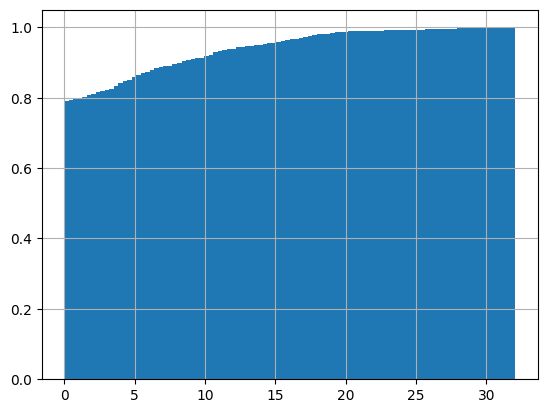

In [235]:
risks = duals2.Risk
risks.sort_values()[:-10].hist(bins=100, cumulative=True, density=True)

In [275]:
print(f"mean: {results.mean_return}")
print(f"volatility: {results.volatility}")
print(f"max drawdown: {results.max_drawdown}")
print(f"max leverage: {results.max_leverage}")
print(f"sharpe: {results.sharpe}")
print(f"turnover: {results.turnover}")

mean: 1.4054113538538715
volatility: 2.7705025554624667
max drawdown: -6.881043671766568
max leverage: 2907.9629280837084
sharpe: 0.5072766856261834
turnover: 837.3384576141522


/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

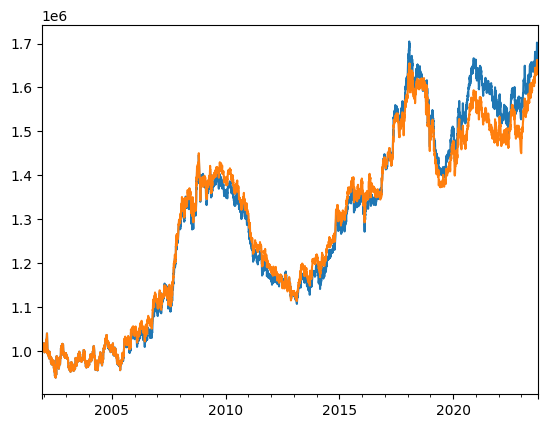

In [280]:
results2.portfolio_value.plot()
results3.portfolio_value.plot()

In [276]:
print(f"mean: {results2.mean_return}")
print(f"volatility: {results2.volatility}")
print(f"max drawdown: {results2.max_drawdown}")
print(f"max leverage: {results2.max_leverage}")
print(f"sharpe: {results2.sharpe}")
print(f"turnover: {results2.turnover}")

mean: 0.02569292023752041
volatility: 0.06832539192035111
max drawdown: -0.23423087079539273
max leverage: 1.6054177148793125
sharpe: 0.3760376562123696
turnover: 14.715135792216339


In [277]:
print(f"mean: {results3.mean_return}")
print(f"volatility: {results3.volatility}")
print(f"max drawdown: {results3.max_drawdown}")
print(f"max leverage: {results3.max_leverage}")
print(f"sharpe: {results3.sharpe}")
print(f"turnover: {results3.turnover}")

mean: 0.02489071927771867
volatility: 0.06771749364194188
max drawdown: -0.2317591518400668
max leverage: 1.6447605262262055
sharpe: 0.36756704861714223
turnover: 14.683478760267239


In [262]:
results3.sharpe

0.45520111960920084

In [257]:
results3.sharpe

0.3187643835940952

(0.0, 0.1)

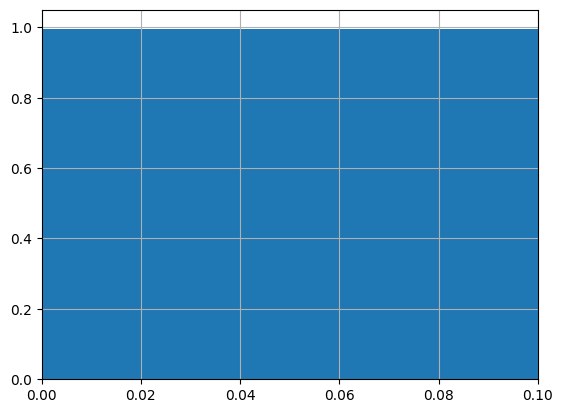

In [232]:
risks.hist(bins=100, cumulative=True, density=True)
plt.xlim(0, 0.1)

<Axes: >

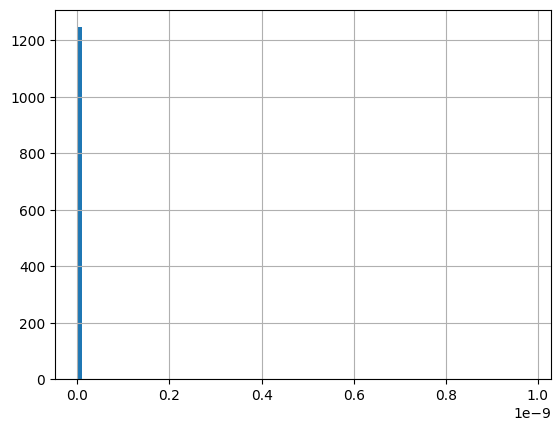

In [225]:
duals2.Turnover.sort_values().hist(bins=100)

(0.0, 0.1)

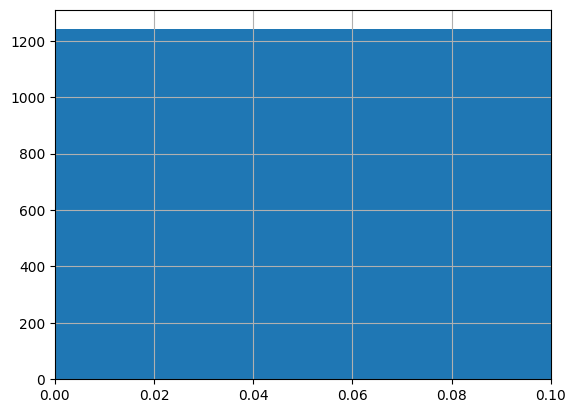

In [215]:
duals2.Risk.hist(bins=100, cumulative=True)
plt.xlim(0,0.1)

In [216]:
duals2.Risk.shape

(1249,)

<Axes: >

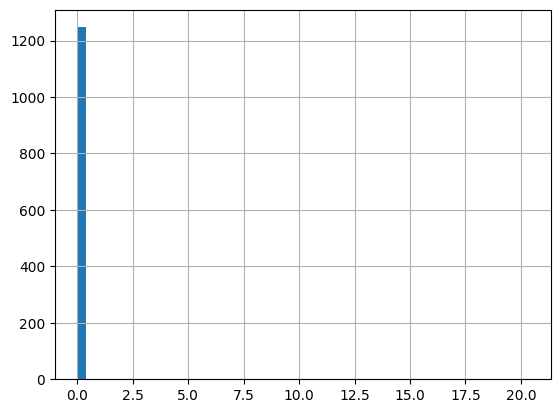

In [188]:
duals2.Risk.hist(bins=50)
# plt.xlim(0.5, 1)

<Axes: >

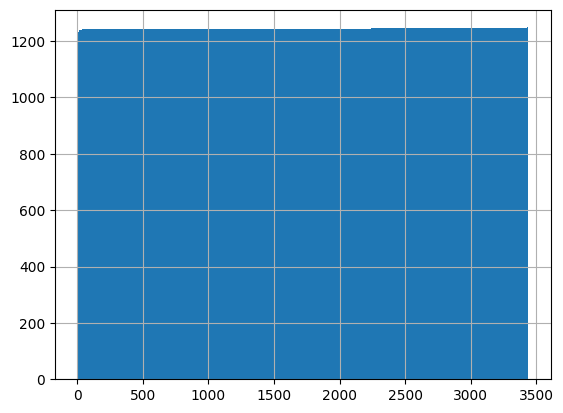

In [204]:
duals2.Turnover.hist(cumulative=True, bins=500)

<Axes: >

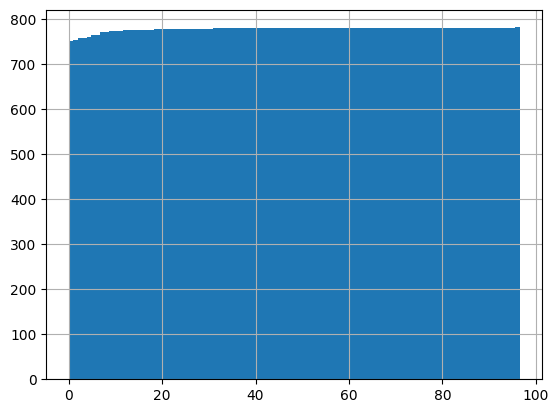

In [198]:
duals.Risk.hist(cumulative=True, bins=100)

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

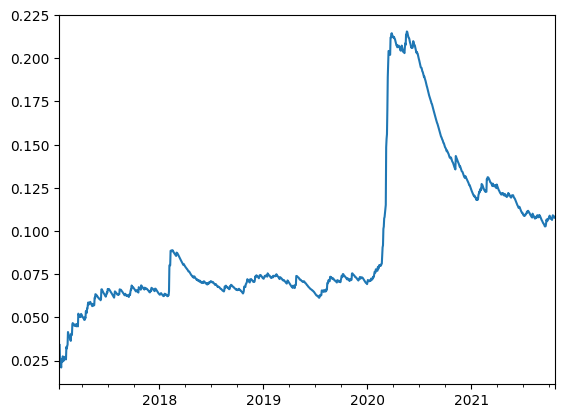

In [134]:
(results.portfolio_returns.ewm(halflife=63).std()*np.sqrt(252)).plot()

In [136]:
results.sharpe

0.6717101394954216

In [114]:
duals.Risk.isna

0.15007211250825284

In [72]:
results.sharpe

0.593913947190349

In [68]:
# shift but dont remove first 4
smoothing_len = 21

returns_new = returns_train.shift(-smoothing_len+1)
returns_new =  pd.concat([returns_train.iloc[:smoothing_len-1], returns_new])
# update first 4 index to be 0,1,2,3
index_new = returns_new.index.tolist()
index_new[:smoothing_len-1] = [i for i in range(smoothing_len-1)]
returns_new.index = index_new


In [69]:
returns_new.rolling(smoothing_len).mean().ffill().dropna()

,T0,T1,T3,T4,T5,T6,T7,T8,T9,T10,...,T89,T90,T92,T93,T94,T95,T96,T98,T99,T100
2015-02-12,-0.002328,-0.001015,0.001383,-0.001818,0.002458,-0.002875,-0.001621,0.002496,-0.004211,-0.003430,...,-0.000203,0.002339,-0.002141,-0.000235,0.001570,0.000196,0.000983,0.002571,0.003087,0.001542
2015-02-13,0.000173,-0.000631,0.001181,-0.002456,0.001192,-0.004100,-0.002171,0.001373,-0.004625,-0.004558,...,-0.000372,0.001336,-0.002612,-0.001016,0.001045,0.000144,0.000299,0.000510,0.002124,0.000480
2015-02-16,0.002125,-0.000009,0.001314,-0.002924,0.001776,-0.004217,-0.001515,0.001518,-0.005325,-0.004568,...,0.000411,0.002250,-0.001418,-0.000358,0.001582,0.000836,0.001635,0.001632,0.002416,0.000407
2015-02-17,0.001868,-0.000319,0.001574,-0.003829,0.001591,-0.004199,-0.001255,0.001336,-0.005623,-0.004950,...,0.000257,0.001701,-0.001658,-0.000672,0.001000,0.000211,0.001295,0.001649,0.002465,0.000561
2015-02-18,0.001728,0.000381,0.001889,-0.002220,0.001356,-0.002409,-0.000945,0.001808,-0.004092,-0.003660,...,0.001397,0.001392,-0.000210,-0.000693,-0.000226,0.000002,0.001604,0.001043,0.003037,0.000748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-20,0.001447,-0.000620,-0.003052,0.000279,0.001611,0.004960,0.000783,-0.001574,0.006977,0.005096,...,0.004540,0.004656,0.004255,0.007559,-0.001629,0.001745,-0.002595,-0.001221,0.004889,0.003185
2021-10-21,0.001447,-0.000620,-0.003052,0.000279,0.001611,0.004960,0.000783,-0.001574,0.006977,0.005096,...,0.004540,0.004656,0.004255,0.007559,-0.001629,0.001745,-0.002595,-0.001221,0.004889,0.003185
2021-10-22,0.001447,-0.000620,-0.003052,0.000279,0.001611,0.004960,0.000783,-0.001574,0.006977,0.005096,...,0.004540,0.004656,0.004255,0.007559,-0.001629,0.001745,-0.002595,-0.001221,0.004889,0.003185
2021-10-25,0.001447,-0.000620,-0.003052,0.000279,0.001611,0.004960,0.000783,-0.001574,0.006977,0.005096,...,0.004540,0.004656,0.004255,0.007559,-0.001629,0.001745,-0.002595,-0.001221,0.004889,0.003185


In [64]:
(-0.064294 + -0.029822	)/2

-0.047058

In [70]:
returns_train.iloc[:21].mean()

T0     -0.002328
T1     -0.001015
T3      0.001383
T4     -0.001818
T5      0.002458
          ...   
T95     0.000196
T96     0.000983
T98     0.002571
T99     0.003087
T100    0.001542
Length: 75, dtype: float64

In [48]:
# 21 day forward smoothing (rolling windom)

returns_train

,T0,T1,T3,T4,T5,T6,T7,T8,T9,T10,...,T89,T90,T92,T93,T94,T95,T96,T98,T99,T100
2015-02-12,-0.064294,-0.005820,0.001152,0.001438,0.020557,0.017905,-0.004718,0.016787,0.013254,0.019536,...,0.008291,0.010640,0.011953,0.004955,0.007259,0.003996,0.005960,0.025479,0.007555,0.017812
2015-02-13,-0.029822,-0.004243,0.011072,0.019156,0.001680,0.017318,-0.004270,0.005696,0.027043,0.010827,...,0.000426,-0.001939,-0.008268,0.003756,0.004404,-0.003591,-0.002684,-0.005171,0.000435,0.008567
2015-02-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-02-17,0.012807,-0.002634,0.001267,0.002936,0.007206,-0.003369,-0.004285,-0.000480,-0.005868,-0.003427,...,0.014172,0.005829,-0.001554,0.007072,0.037336,0.008964,0.003147,0.014199,-0.001956,0.000723
2015-02-18,0.008853,-0.004882,0.008345,-0.006794,-0.012147,-0.017437,-0.001915,-0.002497,-0.025047,-0.021923,...,-0.007686,0.000690,0.007623,0.001073,0.005509,0.005311,0.005058,-0.008250,0.019161,-0.015352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-20,0.012915,0.024067,0.000926,0.015163,0.013466,0.013072,0.008863,-0.003680,0.009292,0.005513,...,0.005819,0.009421,0.014836,0.007637,-0.003355,0.019554,0.000162,0.020378,0.003992,-0.003576
2021-10-21,-0.011860,-0.004102,-0.008466,-0.010039,-0.007844,-0.012549,-0.005126,0.004632,-0.018810,-0.018169,...,-0.010463,0.010711,-0.006898,0.021354,-0.001149,0.009413,0.005414,-0.043636,0.023541,0.003390
2021-10-22,0.054150,-0.008616,-0.006392,-0.001891,0.013451,0.009487,0.001840,-0.011206,0.015149,0.006860,...,0.010698,0.005936,0.008197,0.021908,0.011837,0.007600,0.003914,0.012976,0.008016,0.006556
2021-10-25,-0.025497,-0.006614,-0.000470,0.007775,-0.004890,0.009308,-0.004041,0.015287,0.010565,0.019487,...,0.005333,0.013332,0.011645,0.000445,0.003818,0.001827,0.004617,0.005004,0.004526,-0.000790


In [33]:
results.sharpe

0.6706092750897725

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

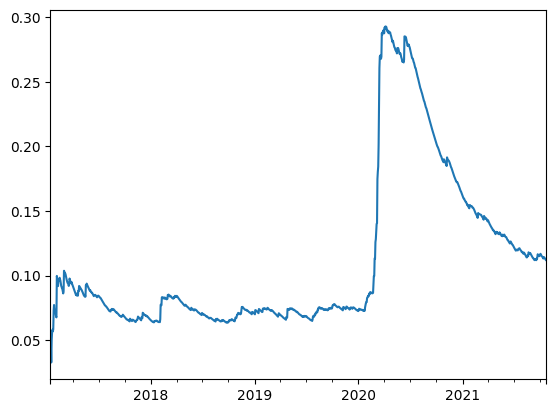

In [32]:
(results.portfolio_returns.ewm(halflife=63).std()*np.sqrt(252)).plot()

In [5]:
parameter_dict, best_iter = tune_parameters(
    full_markowitz,
    prices_train,
    spread_train,
    volume_train,
    rf_train,
    0.1/np.sqrt(252),
)

SolverError
None
Problem status:  None
Problem status:  infeasible_inaccurate
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None


/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1395: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Problem status:  infeasible_inaccurate
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
SolverError
None
Problem status:  None
Problem status:  infeasible_inaccurate
Problem status:  infeasible_inaccurate
Problem status:  infeasible_inaccurate
Problem status:  infeasible_inaccurate
Problem status:  infeasible_inaccurate
Problem status:  infeasible_inaccurate
Problem status:  infeasible_inaccurate
Problem status:  infeasible_inaccurate
Problem status:  infeasible_inaccurate
Problem status:  infeasible_inaccurate
Problem status:  infeasible_inaccurate
Problem status:  infeasible_inaccurate
Problem status:  infeasible_inaccurate
Problem status:  infeasible_inaccurate
Problem status:  infeasible_inaccurate
SolverError
None
Problem status:  None
Problem status:  infeasible_inaccurate
Problem status:  infeasible_inaccurate
Problem status:  infeasible_inaccurate
Problem status:  infeasible_inaccurate
Problem status:  infeasib

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

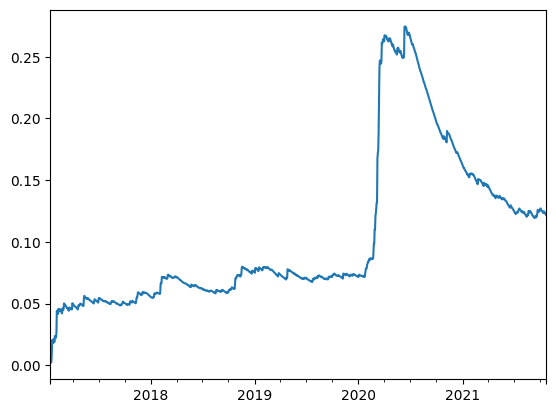

In [23]:
([*parameter_dict.values()][2][1].portfolio_returns.ewm(halflife=63).std()*np.sqrt(252)).plot()

In [323]:
parameter_dict = tune_parameters(
    full_markowitz,
    prices_train,
    spread_train,
    volume_train,
    rf_train,
    0.1/np.sqrt(252),
)

SR: 0.020063744780476556
Iteration number 1; current sharpe: 0.020063744780476556


KeyboardInterrupt: 

In [317]:
for i in range(6):
    print(f"iteration {i}: {parameter_dict[i][1].sharpe}")



iteration 0: 1.1340514710076366


KeyError: 1

In [305]:
res = [*parameter_dict.values()][-1][1]
res.sharpe

0.461541717928363

In [199]:
len([*parameter_dict.values()])

2

In [196]:
params1 = [*parameter_dict.values()][1][0]

IndexError: list index out of range

In [192]:
params1

HyperParameters(gamma_hold=0, gamma_trade=0, gamma_turn=0, gamma_leverage=0, gamma_risk=0)

In [190]:
params

HyperParameters(gamma_hold=1, gamma_trade=1, gamma_turn=0.43961006880888853, gamma_leverage=0.10846804268846431, gamma_risk=5.309493434006647)

In [25]:
params = [*parameter_dict.values()][-1][0]
res = [*parameter_dict.values()][-1][1]

duals = parameter_dict["hard"][2]

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

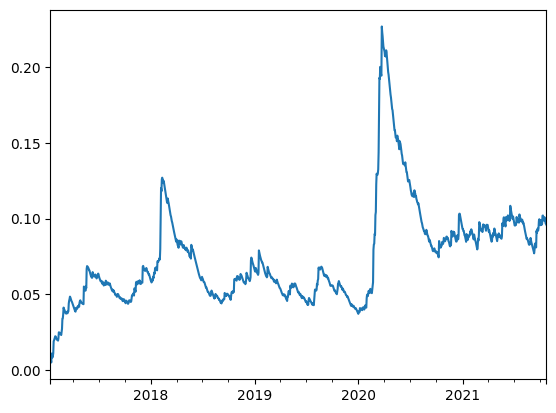

In [38]:
(res.portfolio_returns.ewm(halflife=21).std()*np.sqrt(252)).plot()

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

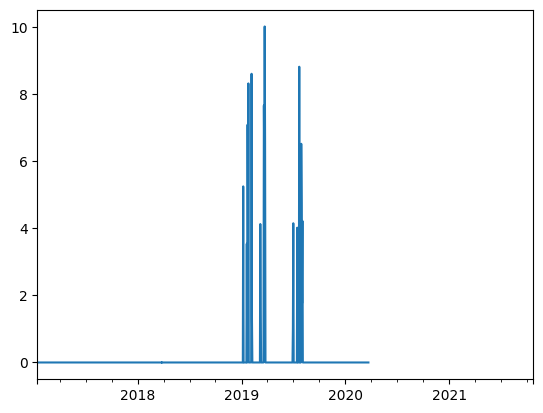

In [127]:
duals.Risk.plot()

In [207]:
duals.Risk.quantile(0.99)


7.291708678908718

In [244]:
hyperparameters

HyperParameters(gamma_hold=1, gamma_trade=1, gamma_turn=1, gamma_leverage=1, gamma_risk=1)

In [259]:
hyperparameters = HyperParameters(
    0, 0, 1, 1, 1
)

results, duals = run_markowitz(
            full_markowitz,
            prices,
            spread,
            volume,
            rf,
            0.1/np.sqrt(252),
            hyperparameters,
            verbose=True,
            hard=False,
        )

Day 500 of 6190, 2001-12-04 00:00:00
Day 600 of 6190, 2002-04-23 00:00:00
Day 700 of 6190, 2002-09-10 00:00:00
Day 800 of 6190, 2003-01-28 00:00:00
Day 900 of 6190, 2003-06-17 00:00:00
Day 1000 of 6190, 2003-11-04 00:00:00
Day 1100 of 6190, 2004-03-23 00:00:00
Day 1200 of 6190, 2004-08-10 00:00:00
Day 1300 of 6190, 2004-12-28 00:00:00
Day 1400 of 6190, 2005-05-17 00:00:00
Day 1500 of 6190, 2005-10-04 00:00:00
Day 1600 of 6190, 2006-02-21 00:00:00
Day 1700 of 6190, 2006-07-11 00:00:00
Day 1800 of 6190, 2006-11-28 00:00:00
Day 1900 of 6190, 2007-04-17 00:00:00
Day 2000 of 6190, 2007-09-04 00:00:00
Day 2100 of 6190, 2008-01-22 00:00:00
Day 2200 of 6190, 2008-06-10 00:00:00
Day 2300 of 6190, 2008-10-28 00:00:00
Day 2400 of 6190, 2009-03-17 00:00:00
Day 2500 of 6190, 2009-08-04 00:00:00
Day 2600 of 6190, 2009-12-22 00:00:00
Day 2700 of 6190, 2010-05-11 00:00:00
Day 2800 of 6190, 2010-09-28 00:00:00
Day 2900 of 6190, 2011-02-15 00:00:00
Day 3000 of 6190, 2011-07-05 00:00:00
Day 3100 of 6190,

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

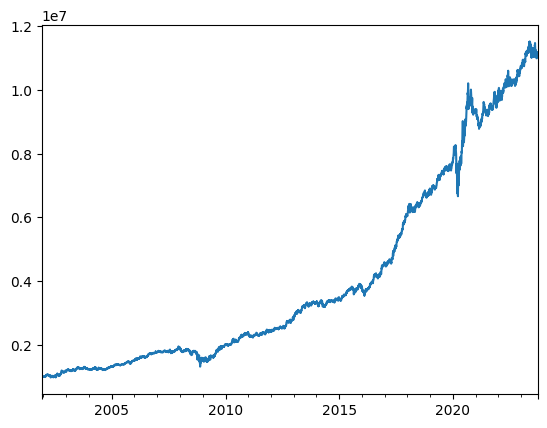

In [260]:
results.portfolio_value.plot()

In [265]:
results.max_drawdown    

-0.32638803873043054

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

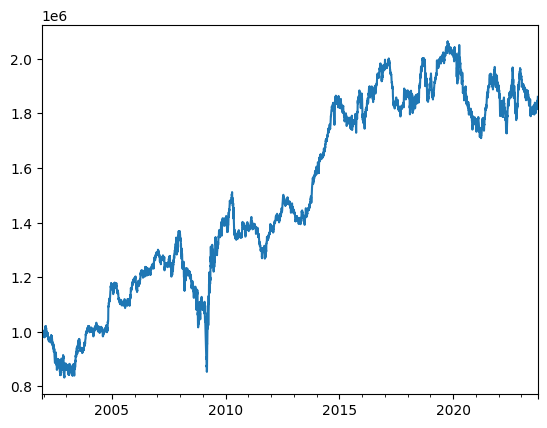

In [256]:
results.portfolio_value.plot()

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

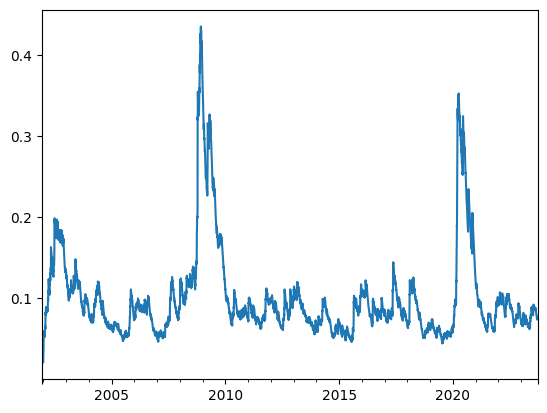

In [266]:
(results.portfolio_returns.ewm(halflife=21).std()*np.sqrt(252)).plot()

In [237]:
hyperparameters.copy()

AttributeError: 'HyperParameters' object has no attribute 'copy'

In [233]:
results.volatility

0.07567858373584031

In [230]:
duals.Risk.min()

26.399360132325086

In [164]:
results.volatility

0.08739814019039631

In [175]:
duals.Risk.quantile(0.95)

0.6879906219654076

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

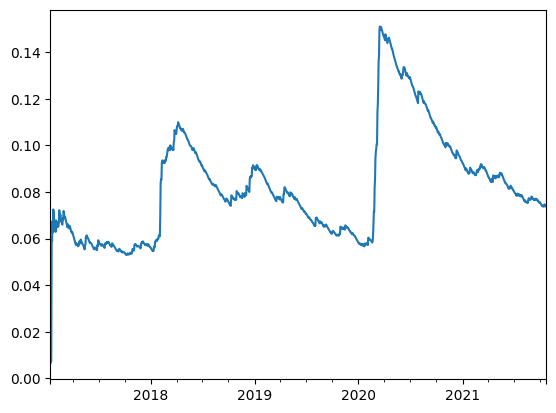

In [166]:
(results.portfolio_returns.ewm(halflife=63).std()*np.sqrt(252)).plot()

In [169]:
(results.portfolio_returns.ewm(halflife=63,min_periods=3).std()*np.sqrt(252)).dropna()

2017-01-16    0.007529
2017-01-17    0.060492
2017-01-18    0.059110
2017-01-19    0.067469
2017-01-20    0.062657
                ...   
2021-10-19    0.074412
2021-10-20    0.074055
2021-10-21    0.074080
2021-10-22    0.073719
2021-10-25    0.074138
Length: 1246, dtype: float64

In [45]:
duals

,FullInvestment,Cash,CLower,CUpper,WLower,WUpper,ZLower,ZUpper,Leverage,Turnover,Risk
2017-01-11,-0.022493,-0.022493,0.0,0.044987,"[8.645497121924764e-11, 8.64822986322676e-11, ...","[5.800290108533934e-11, 5.799849478351272e-11,...","[1.7353178972992174e-10, 1.7420510911588984e-1...","[1.7260021333071972e-10, 1.7196232545446157e-1...",0.0,0.130603,0.0
2017-01-12,-0.0,0.0,0.0,0.0,"[5.018588651634246e-12, 5.022938163623848e-12,...","[3.4946538881237427e-12, 3.4908557875011e-12, ...","[9.587590432590033e-12, 9.602293370062933e-12,...","[9.586888282691358e-12, 9.577822572341868e-12,...",0.0,0.203461,0.0
2017-01-13,0.0,-0.0,0.0,0.0,"[1.515752557183404e-11, 1.514591080735209e-11,...","[1.0449990100511559e-11, 1.0460508939054161e-1...","[2.97196472835524e-11, 2.9618176977133126e-11,...","[2.9427945501515436e-11, 2.95060877016097e-11,...",0.0,0.235401,0.0
2017-01-16,-0.0,0.0,0.0,0.0,"[6.367283836479898e-12, 6.368442563105979e-12,...","[4.3978822845228444e-12, 4.3990596182824394e-1...","[1.2449143416888898e-11, 1.2441485308561364e-1...","[1.2399102256135143e-11, 1.2402581819105919e-1...",0.0,0.176878,0.0
2017-01-17,-0.0,0.0,0.0,0.0,"[1.809540445246482e-12, 1.8071270123336188e-12...","[1.2979713187599259e-12, 1.2990121049300156e-1...","[3.4446674918545197e-12, 3.4424426740040523e-1...","[3.4214121539083812e-12, 3.4251743379707055e-1...",0.0,0.169632,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
results.volatility

0.08998748651468831

In [35]:
duals.Risk.dropna().median()

3.7107741831158124e-07

In [34]:
2.0178709772998465e-06

2.0178709772998465e-06

In [20]:
params

HyperParameters(gamma_hold=1, gamma_trade=0.5, gamma_turn=0.4139728480824029, gamma_leverage=0.06763282443730048, gamma_risk=2.0178709772998465e-06)

In [22]:
res.volatility

0.08413656506603158

In [95]:
res = [*parameter_dict.values()][-1][1]

In [94]:
res = [*parameter_dict.values()][-1][1]

HyperParameters(gamma_hold=1.5, gamma_trade=0.5, gamma_turn=0.8298874131078795, gamma_leverage=5.100934264218233e-09, gamma_risk=18.116732358099316)

In [70]:
results.sharpe

0.5040844840830921

In [62]:
risk_target = 0.1 / np.sqrt(252)
hyperparameters = HyperParameters(
    0, 0, 0, 0, 0
)

results, duals = run_markowitz(
    strategy,
    prices,
    spread,
    volume,
    rf,
    risk_target,
    hyperparameters,
    verbose=True,
) 

Day 500 of 6190, 2001-12-04 00:00:00
Day 600 of 6190, 2002-04-23 00:00:00
Day 700 of 6190, 2002-09-10 00:00:00
Day 800 of 6190, 2003-01-28 00:00:00


/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1395: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Day 900 of 6190, 2003-06-17 00:00:00
Day 1000 of 6190, 2003-11-04 00:00:00
Day 1100 of 6190, 2004-03-23 00:00:00
Day 1200 of 6190, 2004-08-10 00:00:00
Day 1300 of 6190, 2004-12-28 00:00:00
Day 1400 of 6190, 2005-05-17 00:00:00
Day 1500 of 6190, 2005-10-04 00:00:00
Day 1600 of 6190, 2006-02-21 00:00:00
Day 1700 of 6190, 2006-07-11 00:00:00
Day 1800 of 6190, 2006-11-28 00:00:00
Day 1900 of 6190, 2007-04-17 00:00:00
Day 2000 of 6190, 2007-09-04 00:00:00
Day 2100 of 6190, 2008-01-22 00:00:00
Day 2200 of 6190, 2008-06-10 00:00:00
Day 2300 of 6190, 2008-10-28 00:00:00
Day 2400 of 6190, 2009-03-17 00:00:00
Day 2500 of 6190, 2009-08-04 00:00:00
Day 2600 of 6190, 2009-12-22 00:00:00
Day 2700 of 6190, 2010-05-11 00:00:00
Day 2800 of 6190, 2010-09-28 00:00:00
Day 2900 of 6190, 2011-02-15 00:00:00
Day 3000 of 6190, 2011-07-05 00:00:00
Day 3100 of 6190, 2011-11-22 00:00:00
Day 3200 of 6190, 2012-04-10 00:00:00
Day 3300 of 6190, 2012-08-28 00:00:00
Day 3400 of 6190, 2013-01-15 00:00:00
Day 3500 of 6

In [63]:
print(f"mean: {results.mean_return}")
print(f"volatility: {results.volatility}")
print(f"max drawdown: {results.max_drawdown}")
print(f"max leverage: {results.max_leverage}")
print(f"sharpe: {results.sharpe}")
print(f"turnover: {results.turnover}")

mean: 0.04523447537467463
volatility: 0.08973590103046751
max drawdown: -0.2965556038964159
max leverage: 2.504314108737476
sharpe: 0.5040844840830921
turnover: 12.89692623810611


/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

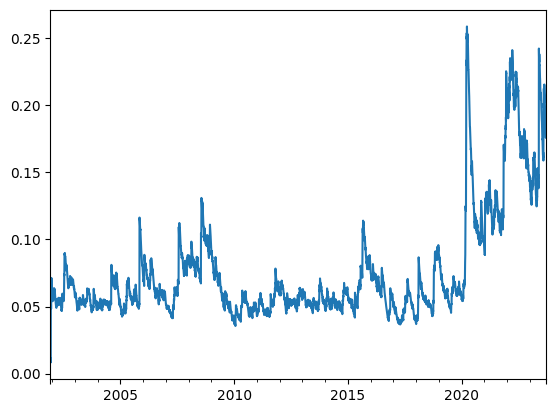

In [64]:
(results.portfolio_returns.ewm(halflife=21).std()*np.sqrt(252)).plot()

In [18]:
cons[0].name

'long_only'

In [3]:
t = returns.index[0]

prices_t = prices.loc[t]
returns_t = returns.loc[t]
spread_t = spread.loc[t]
volume_t = volume.loc[t]
rf_t = rf.loc[t]

Sigma_t = returns.cov()
mu_t = returns.mean()

risk_target = 0.1 / np.sqrt(252) 
T_max = 10 / 252
# T_max = 1

L_max = 1.6

In [4]:
def get_data_and_parameters(inputs, risk_target, T_max, L_max):

    n_assets = inputs.n_assets
    latest_prices = inputs.prices.iloc[-1]
    portfolio_value = inputs.cash + inputs.quantities @ latest_prices

    data = Data(
        w_prev=(inputs.quantities * latest_prices / portfolio_value),
        c_prev=(inputs.cash / portfolio_value),
        idio_mean=np.zeros(n_assets),
        factor_mean=inputs.mean.values,
        risk_free=0,
        factor_covariance_chol=np.linalg.cholesky(inputs.covariance.values),
        idio_volas=np.zeros(n_assets),
        F=np.eye(n_assets),
        kappa_short=np.zeros(n_assets),
        kappa_borrow=0.0,
        kappa_spread=np.zeros(n_assets),
        kappa_impact=np.zeros(n_assets),
    )

    param = Parameters(
        w_lower=-0.1,
        w_upper=0.15,
        c_lower=-0.3,
        c_upper=0.4,
        z_lower=-np.ones(data.n_assets) * 1e3,
        z_upper=np.ones(data.n_assets) * 1e3,
        T_max=T_max,
        L_max=L_max,
        rho_mean=np.zeros(data.n_assets),
        rho_covariance=0.0,
        gamma_hold=0.0,
        gamma_trade=0.0,
        gamma_turn=0.0,
        gamma_risk=0,
        risk_target=risk_target,
        gamma_c_lower=None,
        gamma_c_upper=None,
        gamma_w_lower=None,
        gamma_w_upper=None,
        gamma_z_lower=None,
        gamma_z_upper=None,
        gamma_L_max=None,
    )

    return data, param

def get_data_and_parameters2(inputs, gamma_risk, gamma_turn, gamma_c_lower, gamma_c_upper, gamma_w_lower, gamma_w_upper, gamma_z_lower, gamma_z_upper, gamma_L_max, risk_target, T_max, L_max=1.6):
                             
    n_assets = inputs.n_assets
    latest_prices = inputs.prices.iloc[-1]
    portfolio_value = inputs.cash + inputs.quantities @ latest_prices

    data = Data(
        w_prev=(inputs.quantities * latest_prices / portfolio_value),
        c_prev=(inputs.cash / portfolio_value),
        idio_mean=np.zeros(n_assets),
        factor_mean=inputs.mean.values,
        risk_free=0,
        factor_covariance_chol=np.linalg.cholesky(inputs.covariance.values),
        idio_volas=np.zeros(n_assets),
        F=np.eye(n_assets),
        kappa_short=np.zeros(n_assets),
        kappa_borrow=0.0,
        kappa_spread=np.zeros(n_assets),
        kappa_impact=np.zeros(n_assets),
    )

    # param = Parameters(
    #     w_lower=-0.1,
    #     w_upper=0.15,
    #     c_lower=-0.3,
    #     c_upper=0.4,
    #     z_lower=-np.ones(data.n_assets) * 1e3,
    #     z_upper=np.ones(data.n_assets) * 1e3,
    #     T_max=0,
    #     L_max=L_max,
    #     rho_mean=np.zeros(data.n_assets),
    #     rho_covariance=0.0,
    #     gamma_hold=0.0,
    #     gamma_trade=0.0,
    #     gamma_turn=gamma_turn,
    #     gamma_risk=gamma_risk,
    #     risk_target=inputs.risk_target,
    # )

    param = Parameters(
        w_lower=-0.1,
        w_upper=0.15,
        c_lower=-0.3,
        c_upper=0.4,
        z_lower=-np.ones(data.n_assets) * 1e3,
        z_upper=np.ones(data.n_assets) * 1e3,
        T_max=T_max,
        L_max=L_max,
        rho_mean=np.zeros(data.n_assets),
        rho_covariance=0.0,
        gamma_hold=0.0,
        gamma_trade=0.0,
        gamma_turn=gamma_turn,
        gamma_risk=gamma_risk,
        risk_target=inputs.risk_target,
        gamma_c_lower=gamma_c_lower,
        gamma_c_upper=gamma_c_upper,
        gamma_w_lower=gamma_w_lower,
        gamma_w_upper=gamma_w_upper,
        gamma_z_lower=gamma_z_lower,
        gamma_z_upper=gamma_z_upper,
        gamma_L_max=gamma_L_max,
    )

    

    return data, param


    

In [18]:
import time
import cvxpy as cp
def run_markowitz(
    # strategy: Callable, risk_target: float, verbose: bool = False,
    prices, spread, volume, rf, hard=True, verbose: bool = False,
) -> tuple[pd.Series, pd.DataFrame]:
    """
    Run a simplified backtest for a given strategy.
    At time t we use data from t-lookback to t to compute the optimal portfolio
    weights and then execute the trades at time t.
    """

    # prices, spread, volume, rf = load_data()
    n_assets = prices.shape[1]

    lookback = 500

    # Initialize quantities as equally weighted fully invested portfolio
    prices0 = prices.iloc[lookback]
    quantities = np.ones(n_assets) * (1 / prices0) / np.sum(1 / prices0)
    cash = 0

    post_trade_cash = []
    post_trade_quantities = []

    if hard:
        dual_optimals = pd.DataFrame(columns=["Risk", "Turnover", "CLower", "CUpper", "WUpper", "WLower", "ZUpper", "ZLower", "Leverage"], index=prices.index[lookback:-1])
    
    timings = []

    returns = prices.pct_change().dropna() 
    means = (
        synthetic_returns(prices, information_ratio=0.07).shift(-1).dropna()
    )  # At time t includes data up to t+1
    covariance_df = returns.ewm(halflife=125).cov()  # At time t includes data up to t
    days = returns.index
    covariances = {}
    for day in days:
        covariances[day] = covariance_df.loc[day]

    for t in range(lookback, len(prices) - 1):
        start_time = time.perf_counter()

        day = prices.index[t]

        if verbose and t%100 == 0:
            print(f"Day {t} of {len(prices)-1}, {day}")

        prices_t = prices.iloc[t - lookback : t + 1]  # Up to t
        spread_t = spread.iloc[t - lookback : t + 1]
        volume_t = volume.iloc[t - lookback : t + 1]

        mean_t = means.loc[day]  # Forecast for return t to t+1
        covariance_t = covariances[day]  # Forecast for covariance t to t+1

        inputs_t = OptimizationInput(
            prices_t,
            mean_t,
            covariance_t,
            spread_t,
            volume_t,
            quantities,
            cash,
            risk_target,
            rf.iloc[t],
        )

        data, param = get_data_and_parameters(inputs_t, risk_target, T_max, L_max)

        success = True
        try:
            w, _, problem = markowitz_hard(data, param)
        except (AssertionError, cp.SolverError) as e:
            print("Failed: removing T_max")
            data, param = get_data_and_parameters(inputs_t, risk_target, T_max=1e3, L_max=L_max)
            try :
                success = False
                w, _, problem = markowitz_hard(data, param)
            except (AssertionError, cp.SolverError) as f:
                print("Failed: removing L_max")
                # data, param = get_data_and_parameters(inputs_t, risk_target, T_max=1, L_max=3)
                # w, _, problem = markowitz_hard(data, param)


            

        latest_prices = prices.iloc[t]  # At t
        latest_spread = spread.iloc[t]

        cash += interest_and_fees(
            cash, rf.iloc[t - 1], quantities, prices.iloc[t - 1], day
        )
        trade_quantities = create_orders(w, quantities, cash, latest_prices)
        quantities += trade_quantities
        cash += execute_orders(latest_prices, trade_quantities, latest_spread)

        post_trade_cash.append(cash)
        post_trade_quantities.append(quantities.copy())
        dual_optimals.loc[day, "CLower"] = problem.constraints[2].dual_value
        dual_optimals.loc[day, "CUpper"] = problem.constraints[3].dual_value
        dual_optimals.loc[day, "WLower"] = problem.constraints[4].dual_value
        dual_optimals.loc[day, "WUpper"] = problem.constraints[5].dual_value
        dual_optimals.loc[day, "ZLower"] = problem.constraints[6].dual_value
        dual_optimals.loc[day, "ZUpper"] = problem.constraints[7].dual_value
        dual_optimals.loc[day, "Leverage"] = problem.constraints[8].dual_value
        if success:
            dual_optimals.loc[day, "Turnover"] = problem.constraints[9].dual_value
        else:
            try:
                dual_optimals.loc[day, "Turnover"] = dual_optimals.loc[prices.index[t-1], "Turnover"]
            except KeyError:
                dual_optimals.loc[day, "Turnover"] = problem.constraints[9].dual_value
        success = True
        dual_optimals.loc[day, "Risk"] = problem.constraints[10].dual_value

        # dual_optimals.append(problem.constraints[-1].dual_value)

        # Timings
        end_time = time.perf_counter()
        timings.append(Timing.get_timing(start_time, end_time, problem))

    post_trade_cash = pd.Series(post_trade_cash, index=prices.index[lookback:-1])
    post_trade_quantities = pd.DataFrame(
        post_trade_quantities, index=prices.index[lookback:-1], columns=prices.columns
    )

    return BacktestResult(post_trade_cash, post_trade_quantities, risk_target, timings), dual_optimals

####################
def run_soft_markowitz(
    prices, spread, volume, rf, priorities, verbose: bool = False,
) -> tuple[pd.Series, pd.DataFrame]:
    """
    Run a simplified backtest for a given strategy.
    At time t we use data from t-lookback to t to compute the optimal portfolio
    weights and then execute the trades at time t.
    """

    # prices, spread, volume, rf = load_data()
    n_assets = prices.shape[1]

    lookback = 500
    
    prices0 = prices.iloc[lookback]
    quantities = np.ones(n_assets) * (1 / prices0) / np.sum(1 / prices0)
    cash = 0

    post_trade_cash = []
    post_trade_quantities = []
    timings = []
    risks = pd.Series(index=prices.index[lookback:-1])
    turnovers = pd.Series(index=prices.index[lookback:-1])

    returns = prices.pct_change().dropna() 
    means = (
        synthetic_returns(prices, information_ratio=0.07).shift(-1).dropna()
    )  # At time t includes data up to t+1
    covariance_df = returns.ewm(halflife=125).cov()  # At time t includes data up to t
    days = returns.index
    covariances = {}
    for day in days:
        covariances[day] = covariance_df.loc[day]

    for t in range(lookback, len(prices) - 1):
        start_time = time.perf_counter()

        day = prices.index[t]

        if verbose and t%100 == 0:
            print(f"Day {t} of {len(prices)-1}, {day}")

        prices_t = prices.iloc[t - lookback : t + 1]  # Up to t
        spread_t = spread.iloc[t - lookback : t + 1]
        volume_t = volume.iloc[t - lookback : t + 1]

        mean_t = means.loc[day]  # Forecast for return t to t+1
        covariance_t = covariances[day]  # Forecast for covariance t to t+1

        inputs_t = OptimizationInput(
            prices_t,
            mean_t,
            covariance_t,
            spread_t,
            volume_t,
            quantities,
            cash,
            risk_target,
            rf.iloc[t],
        )

        gamma_risk=priorities.loc[day].Risk
        gamma_turn=priorities.loc[day].Turnover
        gamma_c_lower=priorities.loc[day].CLower
        gamma_c_upper=priorities.loc[day].CUpper
        gamma_w_lower=priorities.loc[day].WLower
        gamma_w_upper=priorities.loc[day].WUpper
        gamma_z_lower=priorities.loc[day].ZLower
        gamma_z_upper=priorities.loc[day].ZUpper
        gamma_L_max=priorities.loc[day].Leverage


        data, param = get_data_and_parameters2(inputs_t, 
                                               gamma_risk=gamma_risk, gamma_turn=gamma_turn, gamma_c_lower=gamma_c_lower, gamma_c_upper=gamma_c_upper, gamma_w_lower=gamma_w_lower, gamma_w_upper=gamma_w_upper, gamma_z_lower=gamma_z_lower, gamma_z_upper=gamma_z_upper, gamma_L_max=gamma_L_max, risk_target=risk_target, T_max=T_max, L_max=L_max)

        w, _, problem = markowitz(data, param)

        latest_prices = prices.iloc[t]  # At t
        latest_spread = spread.iloc[t]

        cash += interest_and_fees(
            cash, rf.iloc[t - 1], quantities, prices.iloc[t - 1], day
        )
        trade_quantities = create_orders(w, quantities, cash, latest_prices)
        quantities += trade_quantities
        cash += execute_orders(latest_prices, trade_quantities, latest_spread)

        post_trade_cash.append(cash)
        post_trade_quantities.append(quantities.copy())

        risk = np.sqrt(np.dot(np.dot(w, covariance_t), w)) * np.sqrt(252)
        turnover = np.sum(np.abs(w - data.w_prev))
        risks.loc[day] = risk
        turnovers.loc[day] = turnover

        # Timings
        end_time = time.perf_counter()
        timings.append(Timing.get_timing(start_time, end_time, problem))

    post_trade_cash = pd.Series(post_trade_cash, index=prices.index[lookback:-1])
    post_trade_quantities = pd.DataFrame(
        post_trade_quantities, index=prices.index[lookback:-1], columns=prices.columns
    )

    return BacktestResult(post_trade_cash, post_trade_quantities, risk_target, timings), risks, turnovers

In [19]:
results, duals = run_backtest(
    # strategy: Callable, risk_target: float, verbose: bool = False,
    prices, spread, volume, rf, True,
)

Day 500 of 6190, 2001-12-04 00:00:00
Failed: removing T_max
Day 600 of 6190, 2002-04-23 00:00:00
Failed: removing T_max
Day 700 of 6190, 2002-09-10 00:00:00
Failed: removing T_max
Failed: removing T_max
Day 800 of 6190, 2003-01-28 00:00:00
Failed: removing T_max
Failed: removing T_max
Day 900 of 6190, 2003-06-17 00:00:00
Day 1000 of 6190, 2003-11-04 00:00:00
Day 1100 of 6190, 2004-03-23 00:00:00
Day 1200 of 6190, 2004-08-10 00:00:00
Day 1300 of 6190, 2004-12-28 00:00:00
Day 1400 of 6190, 2005-05-17 00:00:00
Day 1500 of 6190, 2005-10-04 00:00:00
Day 1600 of 6190, 2006-02-21 00:00:00
Day 1700 of 6190, 2006-07-11 00:00:00
Day 1800 of 6190, 2006-11-28 00:00:00
Day 1900 of 6190, 2007-04-17 00:00:00
Day 2000 of 6190, 2007-09-04 00:00:00
Day 2100 of 6190, 2008-01-22 00:00:00
Failed: removing T_max
Failed: removing T_max
Day 2200 of 6190, 2008-06-10 00:00:00
Failed: removing T_max
Failed: removing T_max
Failed: removing T_max
Failed: removing T_max
Failed: removing T_max
Day 2300 of 6190, 2008

In [33]:
10/252 * 252

10.0

In [35]:
print(f"mean: {results.portfolio_returns.mean() * 252}")
print(f"volatility: {results.portfolio_returns.std() * np.sqrt(252)}")
print(f"max drawdown: {results.max_drawdown}")
print(f"max leverage: {results.max_leverage}")
print(f"sharpe: {results.sharpe}")
print(f"turnover: {results.turnover}")

mean: 0.09888883284649798
volatility: 0.10021556428044409
max drawdown: -0.21454040398029073
max leverage: 1.610985064846046
sharpe: 1.004084261845295
turnover: 18.549502794487584


In [69]:
print(f"mean: {results2.portfolio_returns.mean() * 252}")
print(f"volatility: {results2.portfolio_returns.std() * np.sqrt(252)}")
print(f"max drawdown: {results2.max_drawdown}")
print(f"max leverage: {results2.max_leverage}")
print(f"sharpe: {results2.sharpe}")
print(f"turnover: {results2.turnover}")

mean: 0.11898647918073932
volatility: 0.13668691122539112
max drawdown: -0.2630880870121153
max leverage: 1.9235078483587063
sharpe: 0.8857859130483625
turnover: 16.61892990122609


In [77]:
(4-2*np.sqrt(3))**2

0.2871870788979635

In [83]:
-72/38 + 20*(1-(37/38)**36) - 20 * (37/38)**36

2.790419081085642

In [76]:
print(f"mean: {results2.portfolio_returns.mean() * 252}")
print(f"volatility: {results2.portfolio_returns.std() * np.sqrt(252)}")
print(f"max drawdown: {results2.max_drawdown}")
print(f"max leverage: {results2.max_leverage}")
print(f"sharpe: {results2.sharpe}")
print(f"turnover: {results2.turnover}")

mean: 0.09231373957817875
volatility: 0.10606003538819855
max drawdown: -0.25982737580283366
max leverage: 2.3699631307778994
sharpe: 0.8856714835842171
turnover: 18.785408351372173


/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

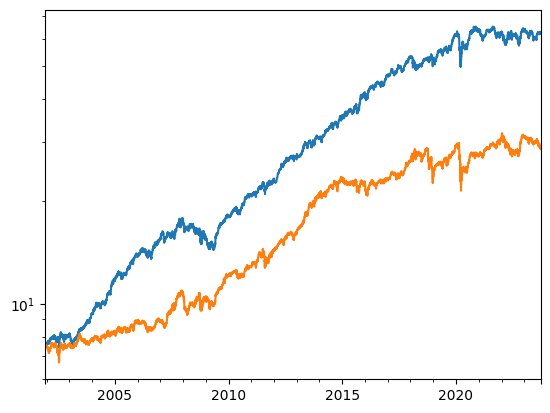

In [73]:
results.portfolio_value.plot()
results2.portfolio_value.plot()

plt.yscale("log")

In [13]:
print(f"mean: {results2.portfolio_returns.mean() * 252}")
print(f"volatility: {results2.portfolio_returns.std() * np.sqrt(252)}")
print(f"max drawdown: {results2.max_drawdown}")
print(f"max leverage: {results2.max_leverage}")
print(f"sharpe: {results2.sharpe}")

mean: 0.10672537668119053
volatility: 0.11644357518590612
max drawdown: -0.19847506847099672
max leverage: 2.983746552565785
sharpe: 0.9326318657509529


In [29]:
results2.portfolio_returns

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/experiments/backtest.py:224: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  return self.portfolio_value.pct_change().dropna()


Series([], dtype: float64)

In [62]:
# create dataframe where rows are duals.WUpper
Wupper = pd.DataFrame([duals.WUpper.values[i] for i in range(duals.shape[0])])
Wupper.index = duals.index
Wupper = Wupper.rolling(100, min_periods=1).quantile(0.8)
WLower = pd.DataFrame([duals.WLower.values[i] for i in range(duals.shape[0])])
WLower.index = duals.index
WLower = WLower.rolling(100, min_periods=1).quantile(0.8)

Zupper = pd.DataFrame([duals.ZUpper.values[i] for i in range(duals.shape[0])])
Zupper.index = duals.index
Zupper = Zupper.rolling(100, min_periods=1).quantile(0.8)
ZLower = pd.DataFrame([duals.ZLower.values[i] for i in range(duals.shape[0])])
ZLower.index = duals.index
ZLower = ZLower.rolling(100, min_periods=1).quantile(0.8)

In [74]:
priorities = pd.DataFrame(index = duals.index, columns=duals.columns)

for t in priorities.index:
    priorities.loc[t]["WUpper"] = Wupper.loc[t].values
    priorities.loc[t]["WLower"] = WLower.loc[t].values
    priorities.loc[t]["ZUpper"] = Zupper.loc[t].values * 0
    priorities.loc[t]["ZLower"] = ZLower.loc[t].values * 0

columns_remaining = ["Risk", "CLower", "CUpper"]
priorities[columns_remaining] = duals[columns_remaining].rolling(100, min_periods=1).quantile(0.99) 

priorities["Leverage"] = duals["Leverage"].rolling(100, min_periods=1).quantile(0.9)
priorities["Turnover"] = duals["Turnover"].rolling(100, min_periods=1).quantile(0.8)

In [18]:
0.00111194306017219 * 1000

1.11194306017219

In [75]:
results2, risks, turnovers = run_backtest2(
    # strategy: Callable, risk_target: float, verbose: bool = False,
    prices, spread, volume, rf, priorities.abs(), True
)

Day 500 of 6190, 2001-12-04 00:00:00
Day 600 of 6190, 2002-04-23 00:00:00
Day 700 of 6190, 2002-09-10 00:00:00
Day 800 of 6190, 2003-01-28 00:00:00
Day 900 of 6190, 2003-06-17 00:00:00
Day 1000 of 6190, 2003-11-04 00:00:00
Day 1100 of 6190, 2004-03-23 00:00:00
Day 1200 of 6190, 2004-08-10 00:00:00
Day 1300 of 6190, 2004-12-28 00:00:00
Day 1400 of 6190, 2005-05-17 00:00:00
Day 1500 of 6190, 2005-10-04 00:00:00
Day 1600 of 6190, 2006-02-21 00:00:00
Day 1700 of 6190, 2006-07-11 00:00:00
Day 1800 of 6190, 2006-11-28 00:00:00
Day 1900 of 6190, 2007-04-17 00:00:00
Day 2000 of 6190, 2007-09-04 00:00:00
Day 2100 of 6190, 2008-01-22 00:00:00
Day 2200 of 6190, 2008-06-10 00:00:00
Day 2300 of 6190, 2008-10-28 00:00:00
Day 2400 of 6190, 2009-03-17 00:00:00
Day 2500 of 6190, 2009-08-04 00:00:00
Day 2600 of 6190, 2009-12-22 00:00:00
Day 2700 of 6190, 2010-05-11 00:00:00
Day 2800 of 6190, 2010-09-28 00:00:00
Day 2900 of 6190, 2011-02-15 00:00:00
Day 3000 of 6190, 2011-07-05 00:00:00
Day 3100 of 6190,

In [68]:
returns

,T0,T1,T3,T4,T5,T6,T7,T8,T9,T10,...,T89,T90,T92,T93,T94,T95,T96,T98,T99,T100
2000-01-05,-0.025398,0.046893,0.060678,0.029942,-0.004416,0.026336,0.021299,0.041501,-0.018286,0.051260,...,0.019823,-0.003551,0.008401,0.020228,0.061013,0.054994,0.003040,-0.023089,0.057692,-0.003393
2000-01-06,0.021220,-0.010311,0.010249,0.044252,0.015084,0.041056,0.001100,-0.030361,0.045847,0.057275,...,0.029155,-0.003563,0.024993,0.026399,0.039316,-0.067926,0.017840,0.045790,-0.005188,0.044150
2000-01-07,0.013300,-0.003173,0.029033,0.032688,0.017481,0.016898,0.063595,-0.023483,-0.010956,-0.005125,...,0.073653,0.023816,0.043161,-0.023890,0.111840,0.020334,0.002893,0.028248,0.000000,0.017886
2000-01-10,0.014358,-0.005315,-0.014089,-0.032829,-0.017181,-0.026313,-0.029896,0.152305,-0.002769,-0.013982,...,-0.039578,0.030227,0.010344,0.009426,-0.004435,-0.003316,-0.040808,-0.012361,0.016973,-0.028758
2000-01-11,0.009299,-0.014956,-0.014326,-0.015756,-0.023602,-0.009245,0.034007,0.010434,-0.001394,0.011941,...,0.003662,-0.027083,-0.002526,-0.008410,0.005941,0.004999,-0.033434,-0.031988,0.050069,-0.019736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-20,-0.013304,0.005988,-0.010319,-0.003790,-0.004230,-0.003050,0.004469,0.007567,-0.016158,-0.007926,...,-0.009253,-0.011908,-0.004376,-0.002342,-0.013918,-0.008057,0.003856,-0.011112,-0.006130,-0.008098
2023-09-21,-0.016027,-0.009226,-0.011958,-0.023617,-0.007822,-0.008999,-0.015400,0.002059,-0.017331,-0.014089,...,-0.034250,-0.020008,-0.018636,-0.014019,-0.004085,0.006722,-0.022040,-0.016209,-0.026053,-0.012829
2023-09-22,-0.010536,-0.000300,-0.011203,0.003786,-0.009583,0.006598,0.001043,-0.017890,0.000756,0.001568,...,0.000745,-0.000570,0.000358,-0.010616,-0.002361,-0.010294,-0.009316,-0.006671,-0.008079,-0.025756
2023-09-25,0.000980,-0.003606,0.005412,0.004431,0.004941,0.014614,-0.010417,-0.002954,0.016029,0.011223,...,0.003179,0.009549,0.004029,0.003446,-0.003737,0.019958,-0.001813,-0.003969,-0.002752,0.008004


/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

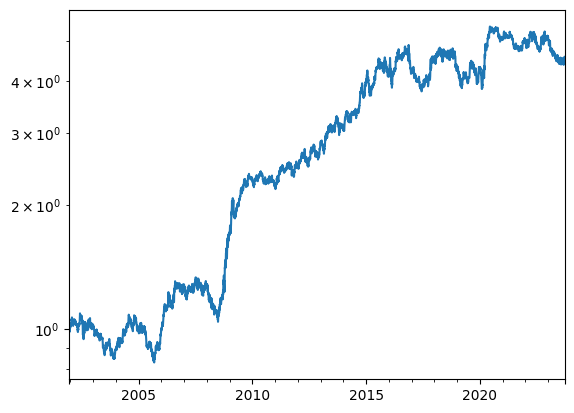

In [126]:
(results2.portfolio_value/results.portfolio_value).plot()
plt.yscale("log")

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

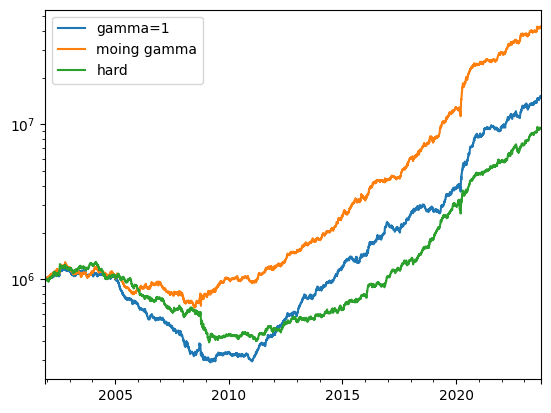

In [133]:
results3.portfolio_value.plot(label="gamma=1")
results2.portfolio_value.plot(label="moing gamma")
results.portfolio_value.plot(label="hard")
plt.legend()
plt.yscale("log")

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

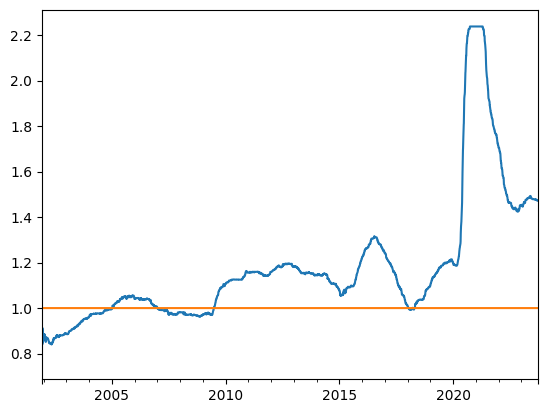

In [135]:
gamma_risks.plot()
gamma_risks3.plot()


In [122]:
(np.array(risks) <= 0.10).mean()

0.7769771528998243

In [116]:
print(f"mean: {results2.portfolio_returns.mean() * 252}")
print(f"volatility: {results2.portfolio_returns.std() * np.sqrt(252)}")
print(f"max drawdown: {results2.max_drawdown}")
print(f"max leverage: {results2.max_leverage}")
print(f"sharpe: {results2.sharpe}")

mean: 0.17344025387119444
volatility: 0.12064983093961906
max drawdown: -0.49037035995050804
max leverage: 7.550241878147584
sharpe: 1.4627875923226943


In [128]:
print(f"mean: {results3.portfolio_returns.mean() * 252}")
print(f"volatility: {results3.portfolio_returns.std() * np.sqrt(252)}")
print(f"max drawdown: {results3.max_drawdown}")
print(f"max leverage: {results3.max_leverage}")
print(f"sharpe: {results3.sharpe}")

mean: 0.12792709614439182
volatility: 0.12783809076710367
max drawdown: -0.756279240047702
max leverage: 7.62225670231688
sharpe: 1.0182639087089391


In [117]:
print(f"mean: {results.portfolio_returns.mean() * 252}")
print(f"volatility: {results.portfolio_returns.std() * np.sqrt(252)}")
print(f"max drawdown: {results.max_drawdown}")
print(f"max leverage: {results.max_leverage}")
print(f"sharpe: {results.sharpe}")

mean: 0.10690152368482325
volatility: 0.1249899715015102
max drawdown: -0.6974539553309929
max leverage: 7.222564873298741
sharpe: 0.8702956470609065


In [ ]:
results2

In [98]:
results.volatility

0.1271842267963638

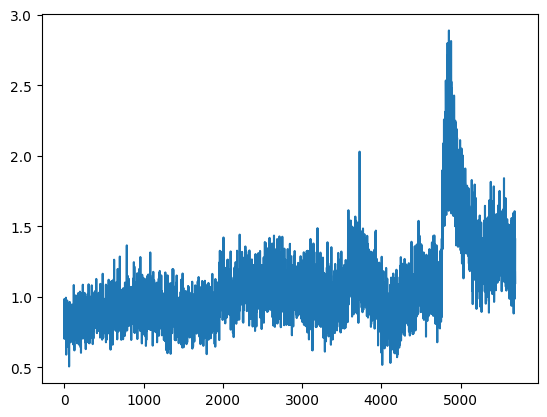

In [47]:
plt.plot(duals)